#Introduction

In this project, I am trying to create model to predict vehicle incurance claim fraud from data provided on kaggle
https://www.kaggle.com/shivamb/vehicle-claim-fraud-detection

#Imports

In [2]:
!pip install skfeature-chappers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 982.3 kB/s eta 0:00:00


In [3]:
#Basic
import pathlib
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp

#Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

#Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from skfeature.function.similarity_based import fisher_score

#Metrics
from sklearn.metrics import roc_auc_score,f1_score, accuracy_score, recall_score, precision_score, average_precision_score, confusion_matrix

#Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

%matplotlib inline

#Loading data

In [4]:
path = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Moje Projekty/fraud_oracle.csv')
df_ = pd.read_csv(path)
df = df_.copy()

#EDA

##Data

In [5]:
df_.head(5)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [6]:
df_.head(5).T

,0,1,2,3,4
Month,Dec,Jan,Oct,Jun,Jan
WeekOfMonth,5,3,5,2,5
DayOfWeek,Wednesday,Wednesday,Friday,Saturday,Monday
Make,Honda,Honda,Honda,Toyota,Honda
AccidentArea,Urban,Urban,Urban,Rural,Urban
DayOfWeekClaimed,Tuesday,Monday,Thursday,Friday,Tuesday
MonthClaimed,Jan,Jan,Nov,Jul,Feb
WeekOfMonthClaimed,1,4,2,1,2
Sex,Female,Male,Male,Male,Female
MaritalStatus,Single,Single,Married,Married,Single


In [7]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

The DataFrame contains 15420 rows and 33 columns. There are no missing values. This indicates that most of the variables are of the "object" type, which typically contains text data or categories. Additionally, there are a few variables of the "int64" type.

In [8]:
df_.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


The provided summary statistics do not show any significant outliers except for the minimum age value of 0, which could potentially be a data entry error or require additional context to understand. Overall, the dataset seems to be within reasonable ranges for the variables, and further exploration can help identify any specific patterns or anomalies.

In [9]:
sns.set_style('darkgrid')

<Axes: xlabel='FraudFound_P', ylabel='count'>

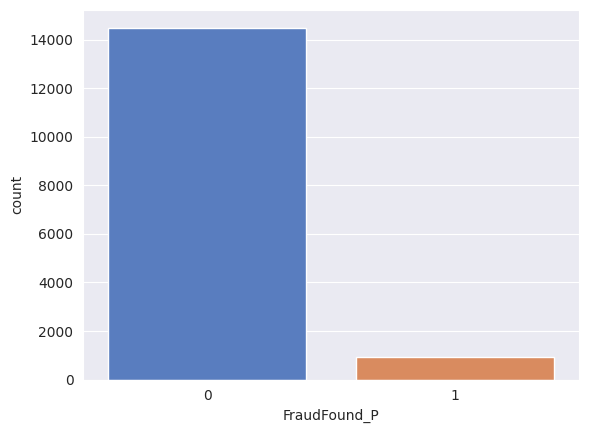

In [10]:
sns.countplot(x='FraudFound_P', data=df_, palette = 'muted')

The results indicate a significant imbalance in the dataset, with a large difference in the number of cases marked as 0 (non-fraud) compared to cases marked as 1 (fraud). This strong class imbalance can affect the effectiveness of analysis and modelling, so it is important to choose the right models.

In [11]:
df.FraudFound_P.value_counts()

0    14497
1      923
Name: FraudFound_P, dtype: int64

##Features

###Age

[Text(0.5, 1.0, 'Not Fraud'), (0.0, 0.06)]

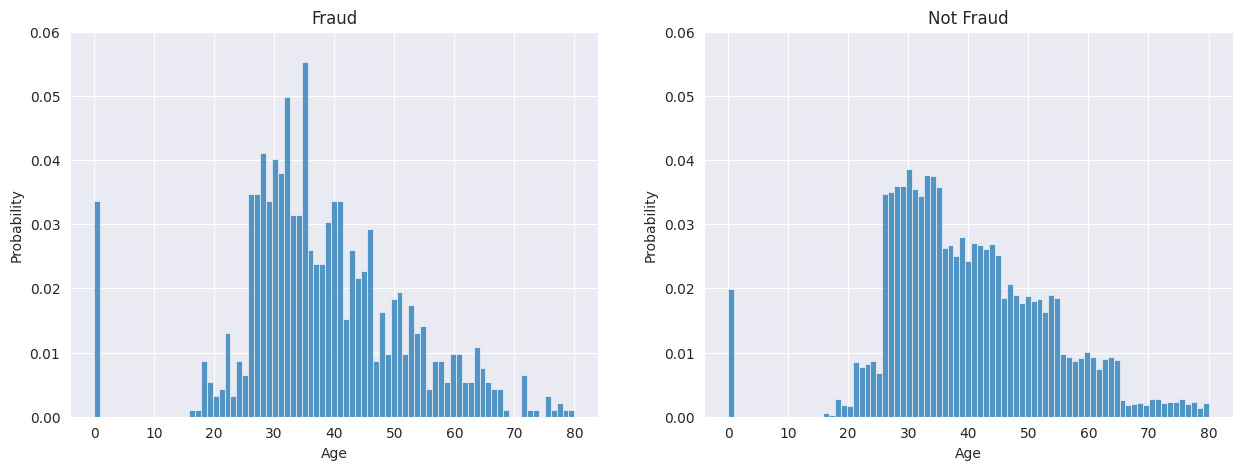

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(df_['Age'][df_['FraudFound_P']==1], bins=81, stat='probability', ax=ax1).set(title='Fraud', ylim=(0, 0.06))
sns.histplot(df_['Age'][df_['FraudFound_P']==0], bins=81, stat='probability', ax=ax2).set(title='Not Fraud', ylim=(0, 0.06))

[Text(0.5, 1.0, 'Distribution of Age for FraudFound_P=1')]

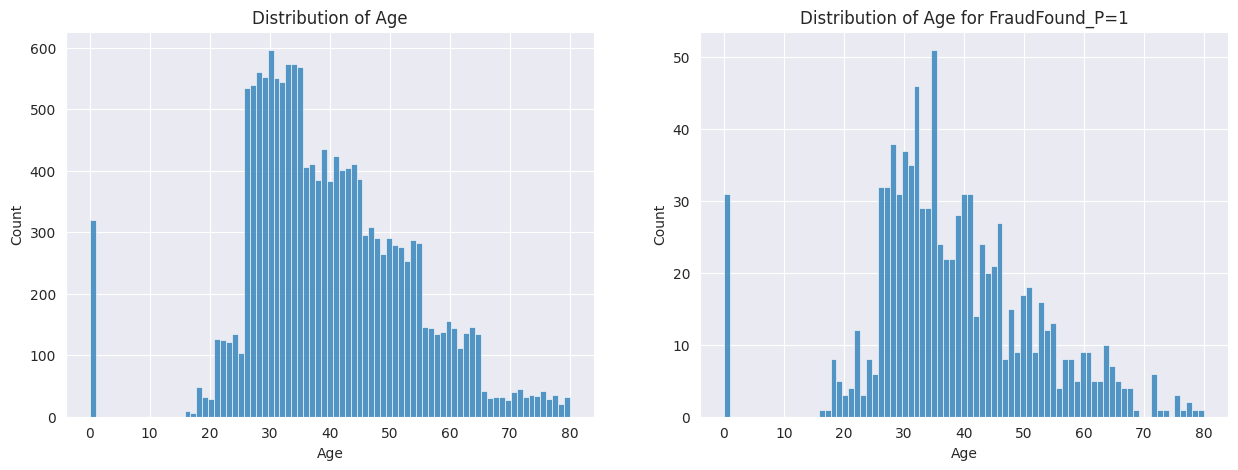

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(df_['Age'], bins=81, ax= ax1).set(title='Distribution of Age')
sns.histplot(df_['Age'][df_['FraudFound_P']==1], bins=81, ax=ax2).set(title='Distribution of Age for FraudFound_P=1')

For Fraud, there is a clear difference in the age distribution compared to the Not Fraud.

Text(0, 0.5, 'Probability of fraud')

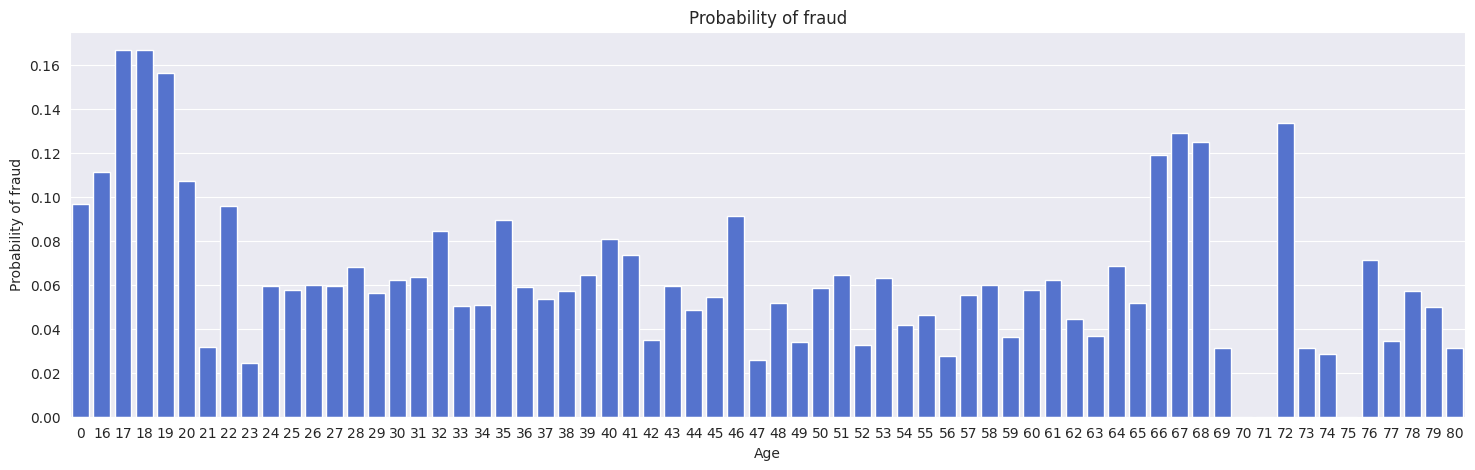

In [14]:
df_age = df.groupby('Age').FraudFound_P.mean().reset_index()

plt.figure(figsize=(18,5))
sns.barplot(data=df_age, x='Age', y='FraudFound_P', color='royalblue')
plt.title('Probability of fraud')
plt.ylabel('Probability of fraud')

 There are ages at which the risk of fraud is higher than at other ages. The highest probability of fraud is for the age of 17, 18 and 19. While the probability is equal zero for the age of 70, 71 and 75.

In [15]:
df['AgeOfPolicyHolder'].unique()

array(['26 to 30', '31 to 35', '41 to 50', '51 to 65', '21 to 25',
       '36 to 40', '16 to 17', 'over 65', '18 to 20'], dtype=object)

<Axes: xlabel='AgeOfPolicyHolder', ylabel='Count'>

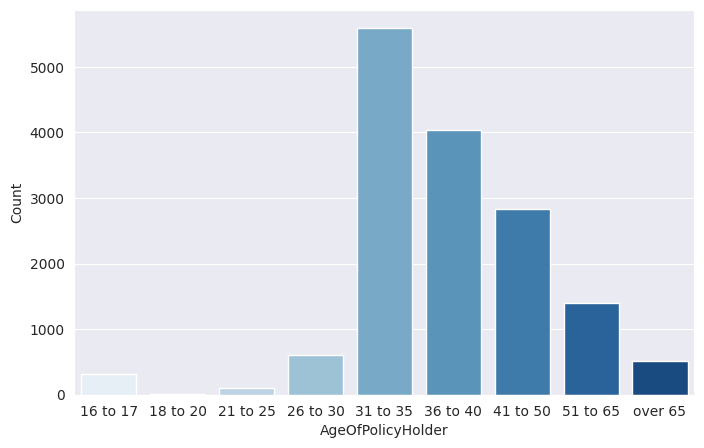

In [16]:
age_holder_order = ['16 to 17','18 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40', '41 to 50', '51 to 65', 'over 65']

df_age_holder_counts = df['AgeOfPolicyHolder'].value_counts().reset_index()
df_age_holder_counts.columns = ['AgeOfPolicyHolder', 'Count']

plt.figure(figsize=(8,5))
sns.barplot(data=df_age_holder_counts, x='AgeOfPolicyHolder', y='Count',
            order=age_holder_order, palette='Blues')

Most cases of claim occur in the age group of 31 to 35 years.

Text(0, 0.5, 'Probability of fraud')

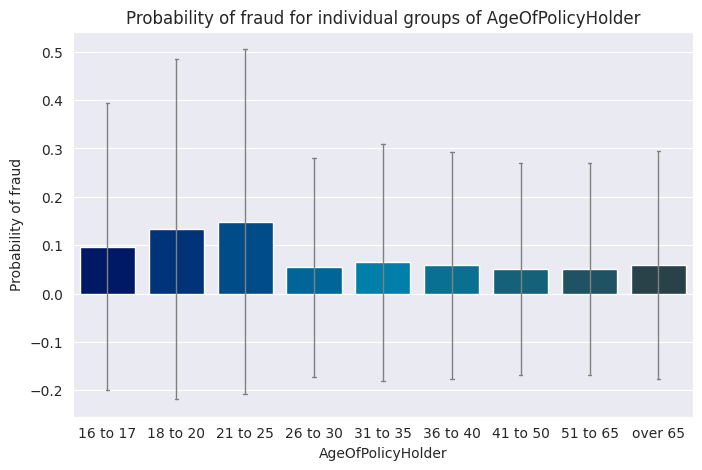

In [17]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_, x='AgeOfPolicyHolder', y='FraudFound_P',
            capsize=0.05,
            saturation=8,
            errcolor='gray',
            errwidth=1,
            errorbar='sd',
            order=age_holder_order,
            palette='ocean_d')
plt.title('Probability of fraud for individual groups of AgeOfPolicyHolder')
plt.ylabel('Probability of fraud')

The groups of the highest risk are 21 to 25, 18 to 20 and 16 to 17.

###Month

In [18]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Fraud', 'Not Fraud'))

fig1 = px.histogram(df[df['FraudFound_P']==1], x='Month', histnorm='probability')
fig2 = px.histogram(df[df['FraudFound_P']==0], x='Month', histnorm='probability')

fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.update_xaxes(matches='x', categoryorder='array', categoryarray=month_order)

fig.update_layout(title_text="Comparison of Fraud vs. Not Fraud",
                  width=1000, height=500,
                  title_x=0.5,
                  showlegend=False)

fig.update_yaxes(range=[0, 0.12], row=1, col=1)
fig.update_yaxes(range=[0, 0.12], row=1, col=2)

fig.update_xaxes(title_text="Month", row=1, col=1)
fig.update_yaxes(title_text="Probability", row=1, col=1)

fig.update_xaxes(title_text="Month", row=1, col=2)
fig.update_yaxes(title_text="Probability", row=1, col=2)

The distribution of claims varies depending on whether they involve frauds or not

In [19]:
df_month = pd.DataFrame(df_.groupby('Month').FraudFound_P.mean().reset_index())
df_month.columns = ['Month', 'Probability_Of_Fraud']
df_month

,Month,Probability_Of_Fraud
0,Apr,0.062500
1,Aug,0.074534
2,Dec,0.048249
3,Feb,0.064771
4,Jan,0.061658
5,Jul,0.047733
6,Jun,0.060560
7,Mar,0.075000
8,May,0.068764
9,Nov,0.038301


Text(0.5, 1.0, 'Probability of fraud for indyvidual months')

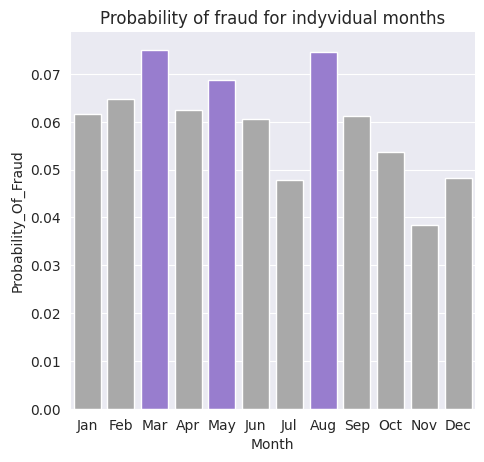

In [20]:
month_palette = ['darkgray', 'darkgray', 'mediumpurple', 'darkgray', 'mediumpurple', 'darkgray', 'darkgray', 'mediumpurple', 'darkgray', 'darkgray', 'darkgray', 'darkgray']

sns.catplot(data=df_month, x='Month', y='Probability_Of_Fraud', kind='bar',
            palette=month_palette, order=month_order,
            height=4.5, aspect=1.1)
plt.title('Probability of fraud for indyvidual months')

Amongst fraudulent cases months of March, Aug and May has relatively higher probablity.

In [21]:
df_['MonthClaimed'].unique()

array(['Jan', 'Nov', 'Jul', 'Feb', 'Mar', 'Dec', 'Apr', 'Aug', 'May',
       'Jun', 'Sep', 'Oct', '0'], dtype=object)

In [22]:
df_[df_['MonthClaimed']=='0']

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
1516,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils


In [23]:
df.drop(1516, axis=0, inplace=True)

###Week of Month

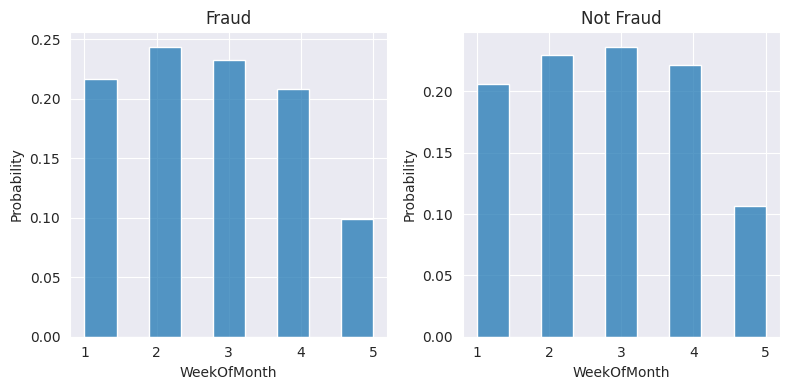

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[8,4])

sns.histplot(data=df_[df_['FraudFound_P']==1], x='WeekOfMonth', stat='probability', ax=ax1, bins=9).set(title='Fraud')
sns.histplot(data=df_[df_['FraudFound_P']==0], x='WeekOfMonth', stat='probability', ax=ax2, bins=9).set(title='Not Fraud')
plt.tight_layout()

###Make

[Text(0.5, 1.0, 'The number of claims for different makes of cars')]

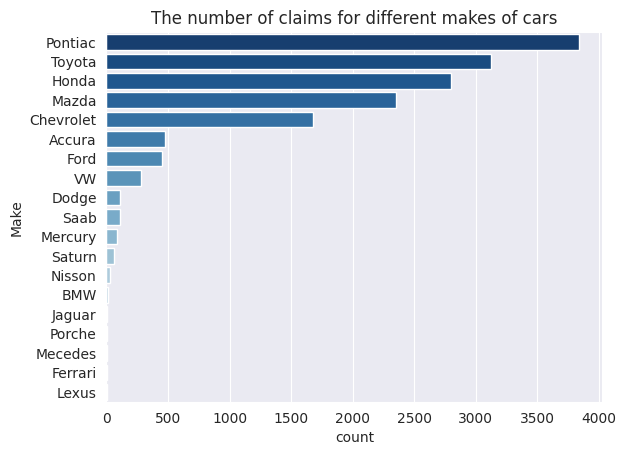

In [25]:
make_order = df_['Make'].value_counts().index
sns.countplot(y=df_['Make'], palette='Blues_r',
              order=make_order).set(title='The number of claims for different makes of cars')

Pontiac, Toyota, Honda, Mazda and Chevrolet are the top 5 makes involved in claims.

Text(0, 0.5, 'Probability of Fraud')

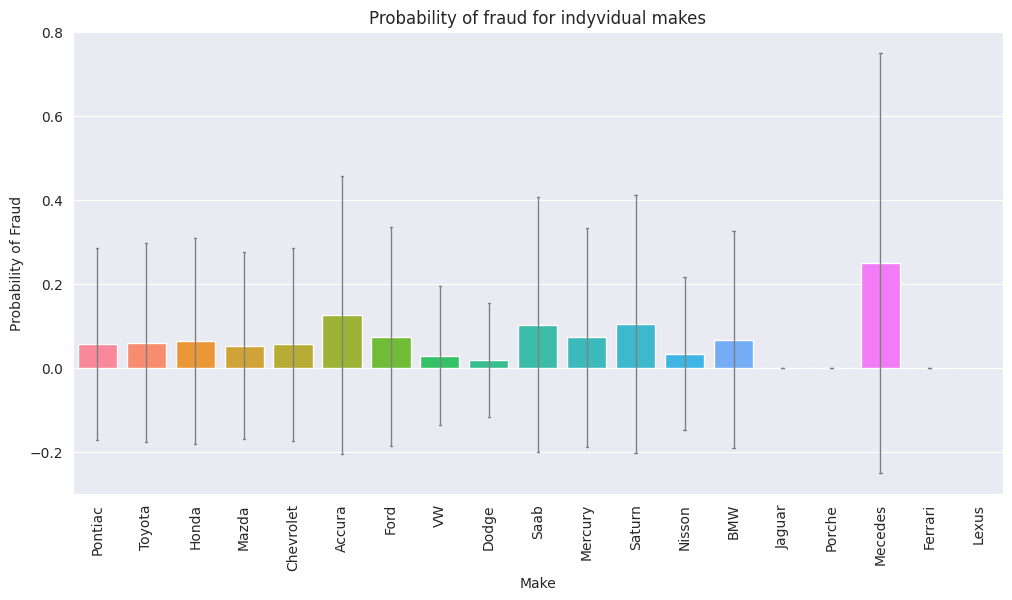

In [26]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_, x='Make', y='FraudFound_P',
            capsize = 0.05,
            saturation = 8,
            errcolor = 'gray', errwidth = 1,
            order=make_order,
            errorbar = 'sd' )
plt.xticks(rotation=90)
plt.title('Probability of fraud for indyvidual makes')
plt.ylabel('Probability of Fraud')

Surprisingly the highest probability of fraudulent transactions is in high end cars like Accura and Mercedes, most likely due to higher incentive for frauds as the cars being more expensive

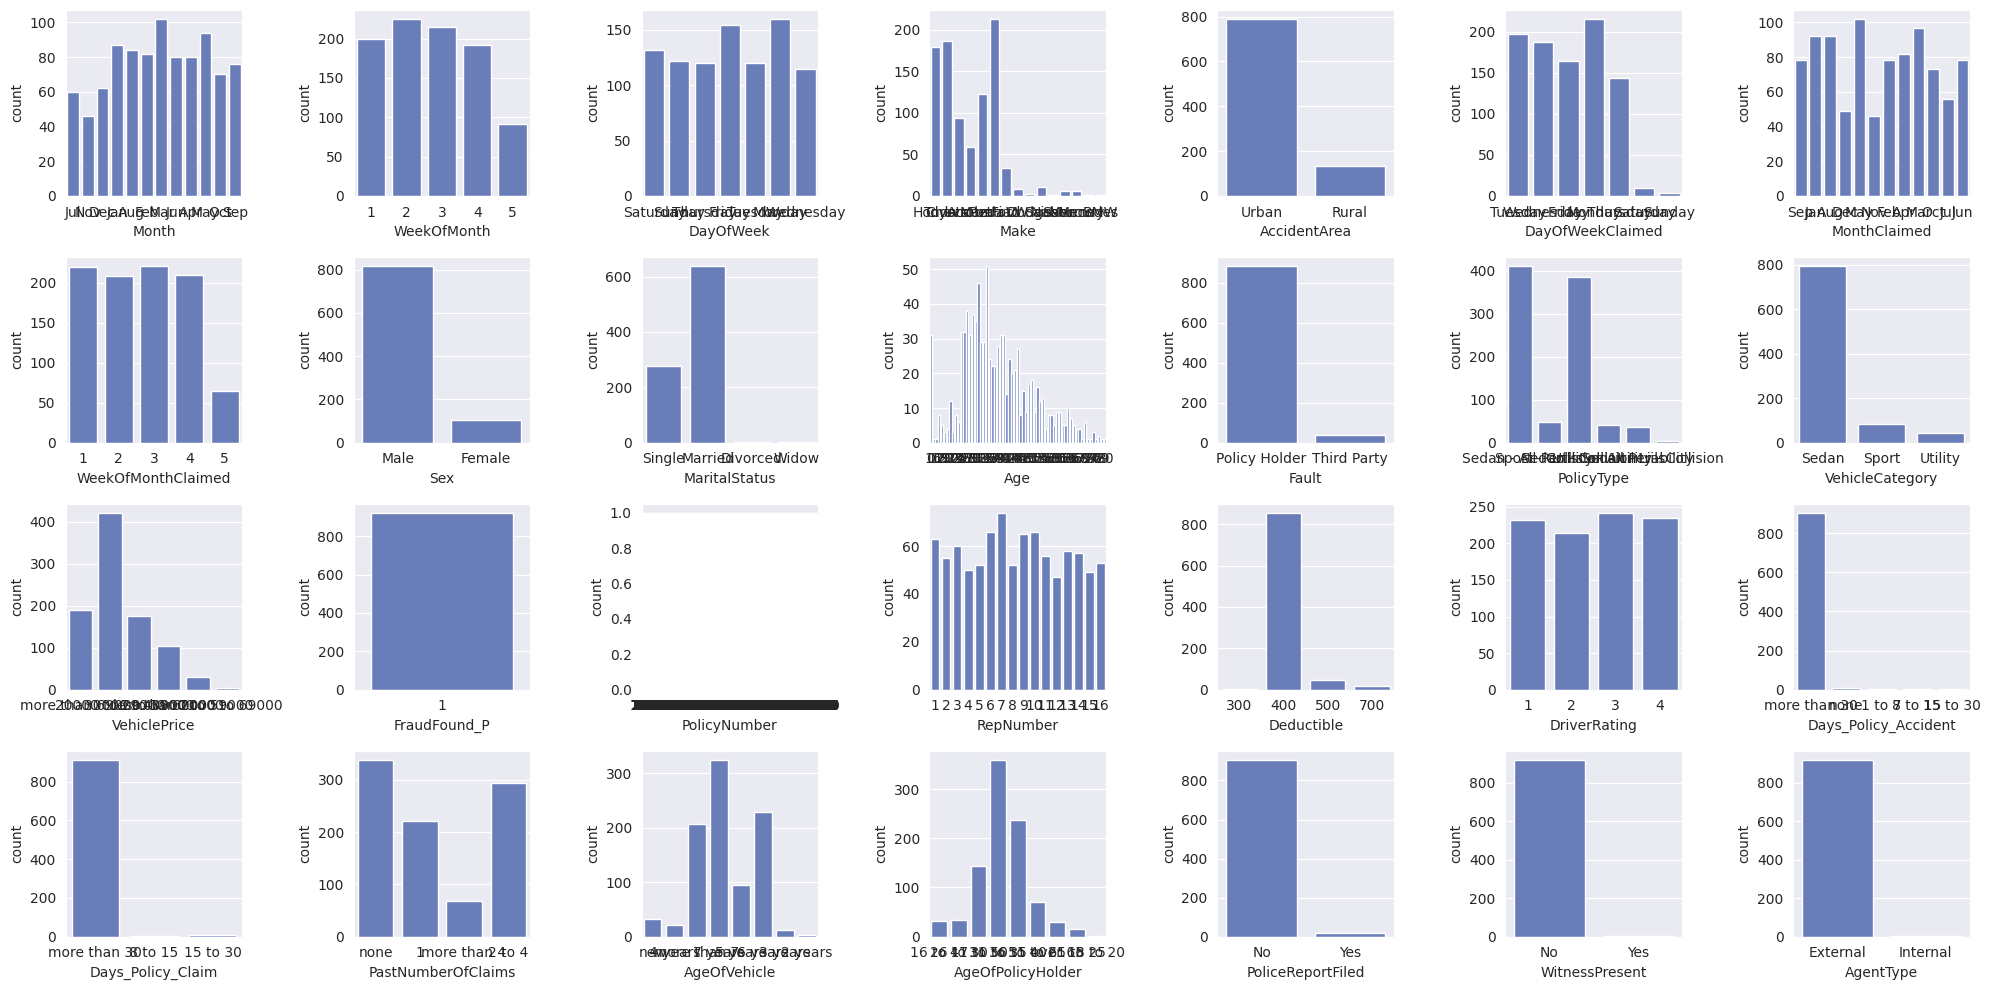

In [27]:
fig, axs = plt.subplots(ncols=7, nrows=4, figsize=(20,10))
index = 0
ddf=df_[df_['FraudFound_P']==1].copy()
axs = axs.flatten()
for k,v in ddf.iloc[:, 0:28].items():
    sns.countplot(x=v, ax=axs[index], color='royalblue', saturation=0.5)
    index = index + 1
plt.tight_layout()

You can see that the probability of fraud is surprisingly high for Mercedes. There is also an increased risk of fraud for Accura, Ford, Saab, Mercury and Saturn.

<Axes: xlabel='DayOfWeek', ylabel='Count'>

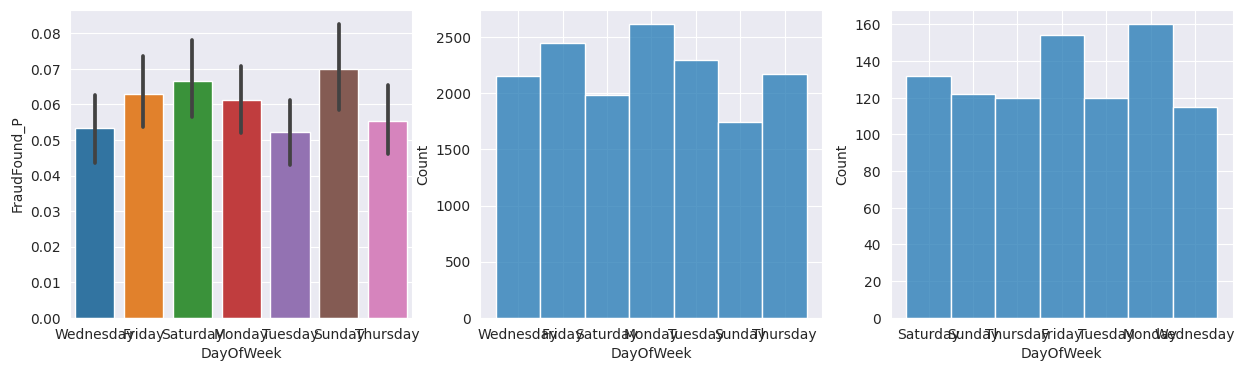

In [85]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
sns.barplot(data=df_, x='DayOfWeek', y='FraudFound_P', ax=ax1)
sns.histplot(df['DayOfWeek'], ax=ax2)
sns.histplot(df['DayOfWeek'][df['FraudFound_P']==1], ax=ax3)

<Axes: xlabel='AccidentArea', ylabel='Count'>

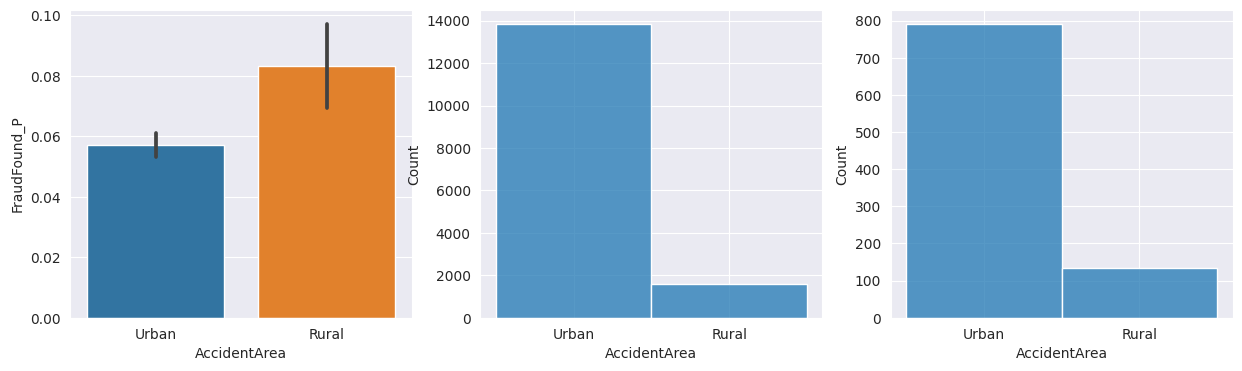

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
sns.barplot(data=df_, x='AccidentArea', y='FraudFound_P', ax=ax1)
sns.histplot(df_['AccidentArea'], ax=ax2)
sns.histplot(df['AccidentArea'][df['FraudFound_P']==1], ax=ax3)

In [90]:
df['FraudFound_P'][df['AccidentArea']=='Rural'].sum()

133

<Axes: xlabel='Sex', ylabel='Count'>

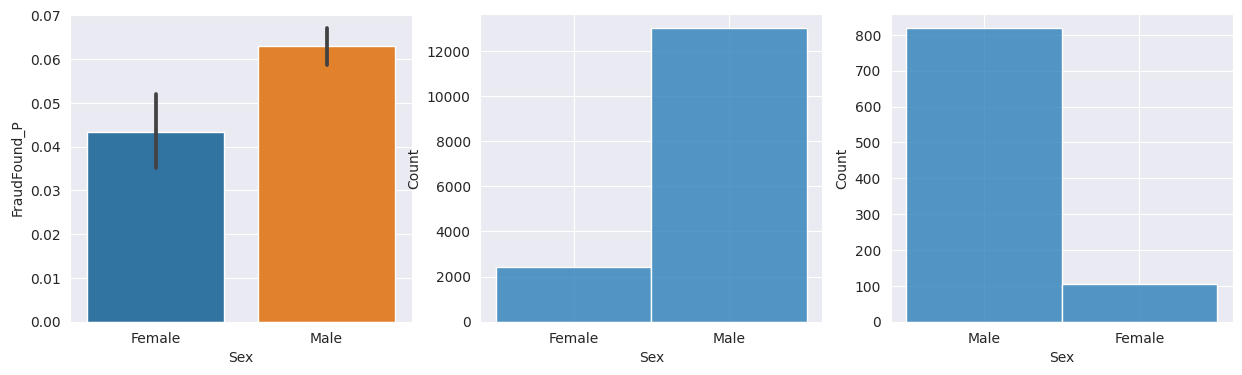

In [91]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
sns.barplot(data=df_, x='Sex', y='FraudFound_P', ax=ax1)
sns.histplot(df_['Sex'], ax=ax2)
sns.histplot(df['Sex'][df['FraudFound_P']==1], ax=ax3)

<Axes: xlabel='MaritalStatus', ylabel='Count'>

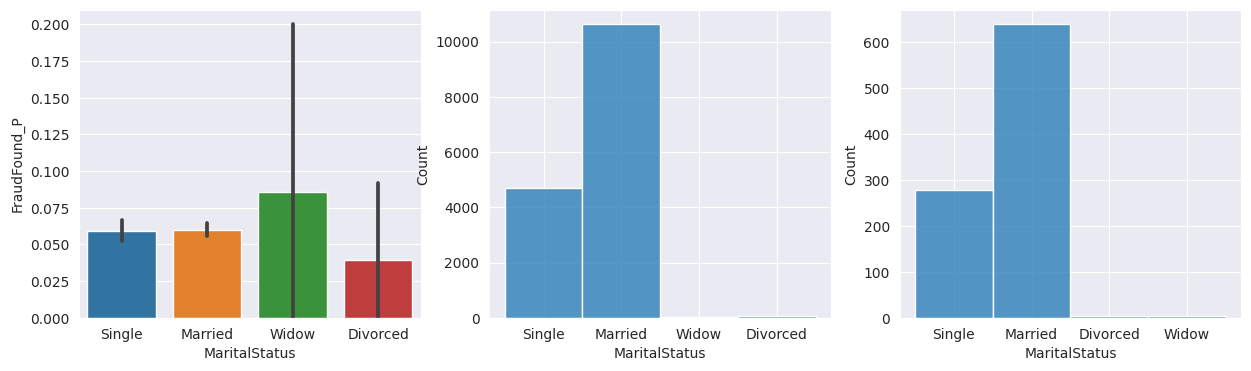

In [92]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
sns.barplot(data=df_, x='MaritalStatus', y='FraudFound_P', ax=ax1)
sns.histplot(df_['MaritalStatus'], ax=ax2)
sns.histplot(df['MaritalStatus'][df['FraudFound_P']==1], ax=ax3)

<Axes: xlabel='Count', ylabel='PolicyType'>

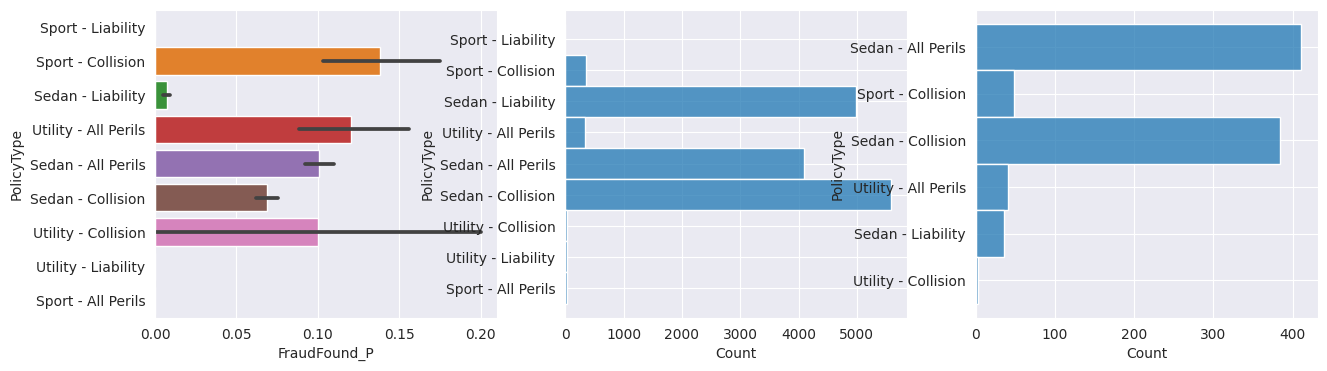

In [116]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
sns.barplot(data=df, y='PolicyType', x='FraudFound_P', ax=ax1)
sns.histplot(y=df['PolicyType'], ax=ax2)
sns.histplot(y=df['PolicyType'][df['FraudFound_P']==1], ax=ax3)

<Axes: xlabel='Count', ylabel='VehiclePrice'>

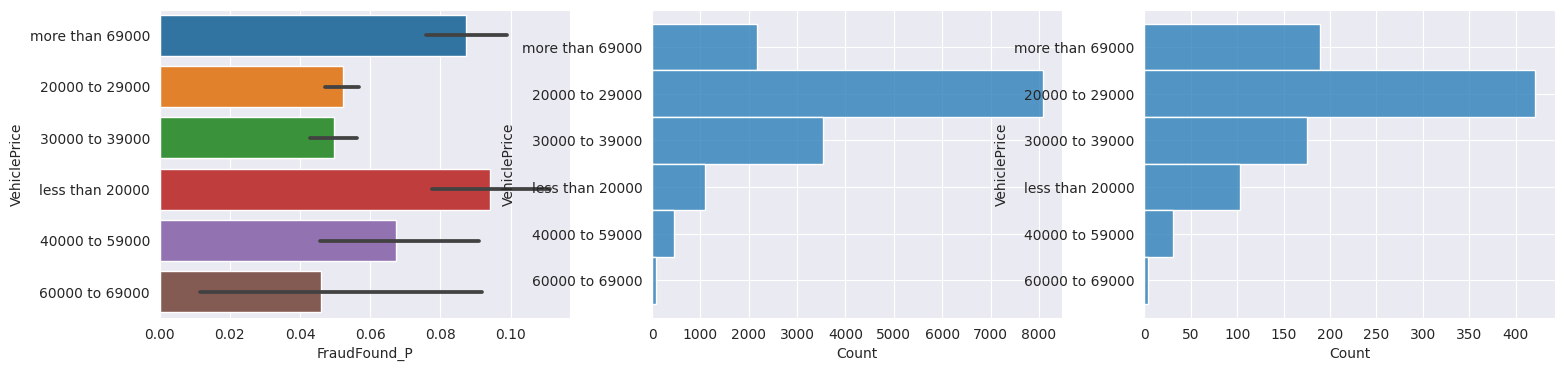

In [95]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
sns.barplot(data=df_, y='VehiclePrice', x='FraudFound_P', ax=ax1)
sns.histplot(y=df_['VehiclePrice'], ax=ax2)
sns.histplot(y=df['VehiclePrice'][df['FraudFound_P']==1], ax=ax3)

<Axes: xlabel='RepNumber', ylabel='Count'>

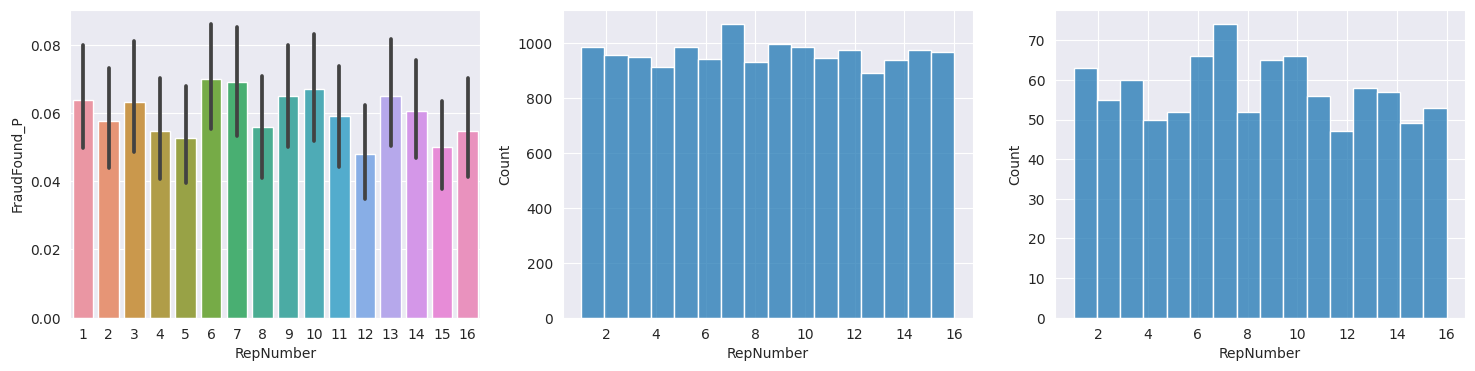

In [97]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
sns.barplot(data=df_, x='RepNumber', y='FraudFound_P', ax=ax1)
sns.histplot(df['RepNumber'], ax=ax2, bins=16)
sns.histplot(df['RepNumber'][df['FraudFound_P']==1], bins=16, ax=ax3)

<Axes: xlabel='Deductible', ylabel='Count'>

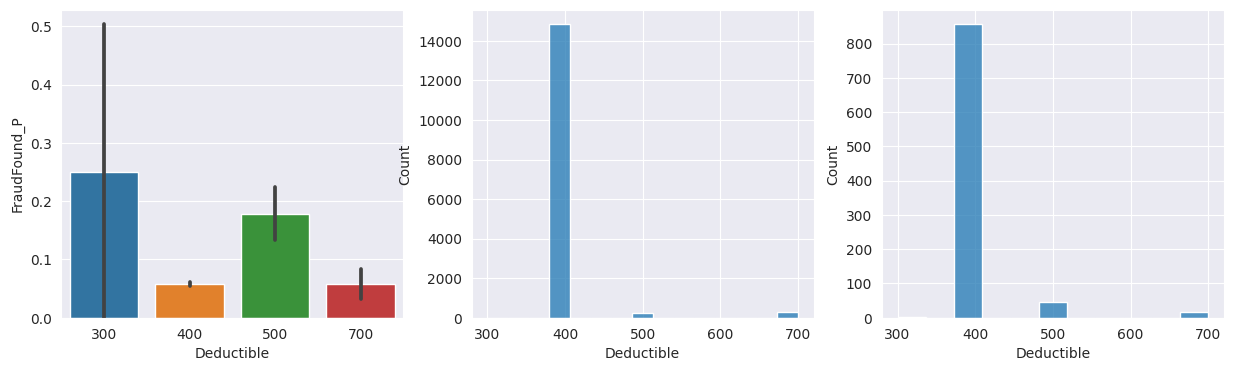

In [99]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
sns.barplot(data=df, x='Deductible', y='FraudFound_P', ax=ax1)
sns.histplot(df['Deductible'], ax=ax2)
sns.histplot(df['Deductible'][df['FraudFound_P']==1], ax=ax3)

<Axes: xlabel='DriverRating', ylabel='Count'>

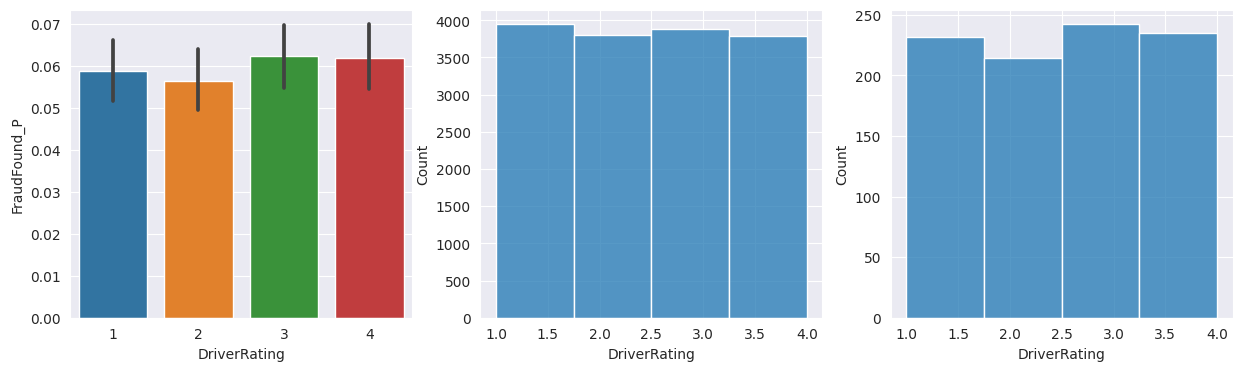

In [101]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
sns.barplot(data=df, x='DriverRating', y='FraudFound_P', ax=ax1)
sns.histplot(df['DriverRating'], bins=4, ax=ax2)
sns.histplot(df['DriverRating'][df['FraudFound_P']==1], bins=4, ax=ax3)

<Axes: xlabel='Days_Policy_Accident', ylabel='Count'>

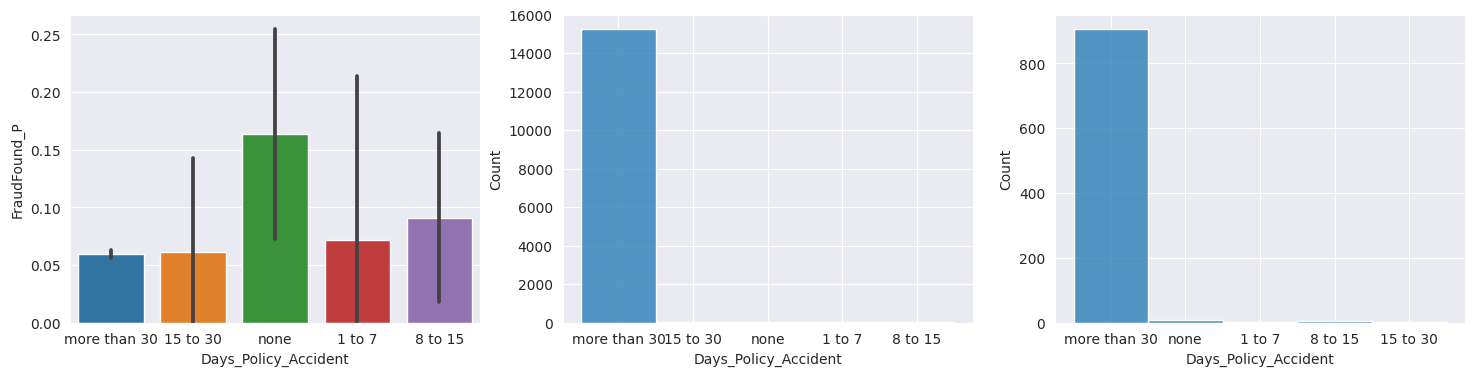

In [102]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
sns.barplot(data=df, x='Days_Policy_Accident', y='FraudFound_P', ax=ax1)
sns.histplot(df['Days_Policy_Accident'], ax=ax2)
sns.histplot(df['Days_Policy_Accident'][df['FraudFound_P']==1], ax=ax3)

In [66]:
df[df['Days_Policy_Accident']!='more than 30']['FraudFound_P'].sum()

18

In [62]:
df['FraudFound_P'][df['Days_Policy_Accident']=='none'].sum()

9

<Axes: xlabel='Days_Policy_Claim', ylabel='Count'>

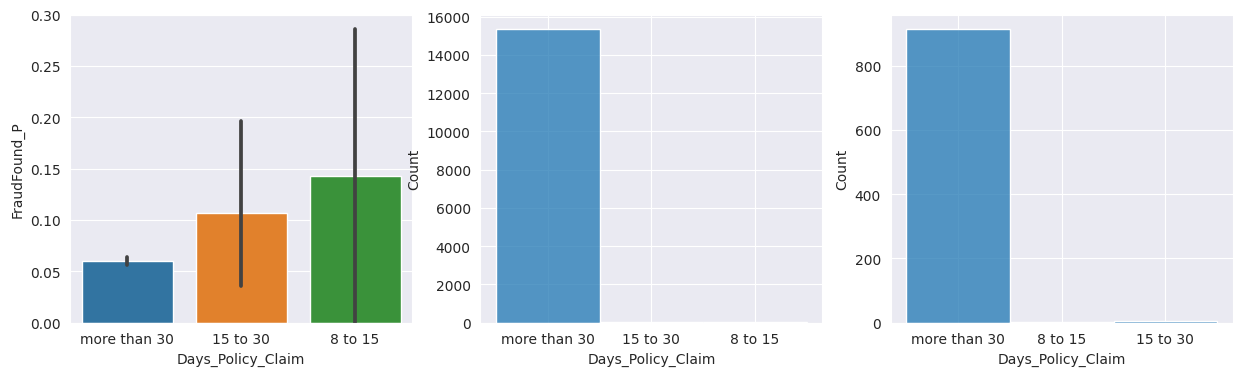

In [103]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
sns.barplot(data=df, x='Days_Policy_Claim', y='FraudFound_P', ax=ax1)
sns.histplot(df['Days_Policy_Claim'], ax=ax2)
sns.histplot(df['Days_Policy_Claim'][df['FraudFound_P']==1], ax=ax3)

<Axes: xlabel='PastNumberOfClaims', ylabel='Count'>

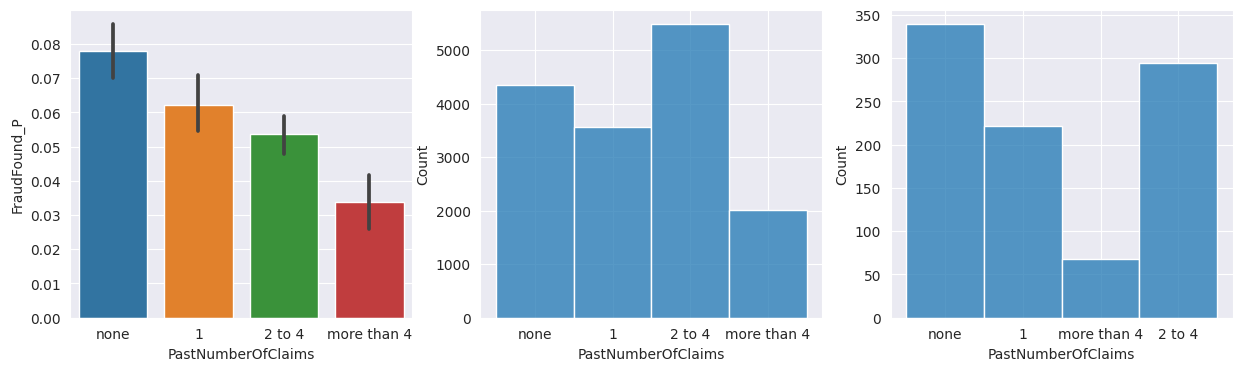

In [104]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
sns.barplot(data=df_, x='PastNumberOfClaims', y='FraudFound_P', ax=ax1)
sns.histplot(df_['PastNumberOfClaims'], ax=ax2)
sns.histplot(df['PastNumberOfClaims'][df['FraudFound_P']==1], ax=ax3)

<Axes: xlabel='AgeOfVehicle', ylabel='Count'>

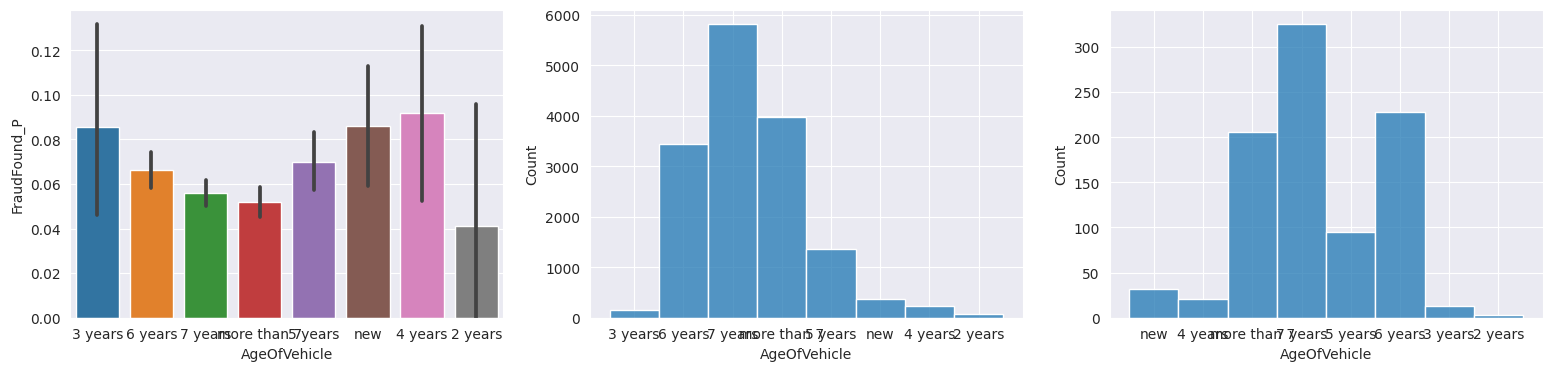

In [107]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19,4))
sns.barplot(data=df, x='AgeOfVehicle', y='FraudFound_P', ax=ax1)
sns.histplot(df['AgeOfVehicle'], ax=ax2)
sns.histplot(df['AgeOfVehicle'][df['FraudFound_P']==1], ax=ax3)

<Axes: xlabel='AgeOfPolicyHolder', ylabel='Count'>

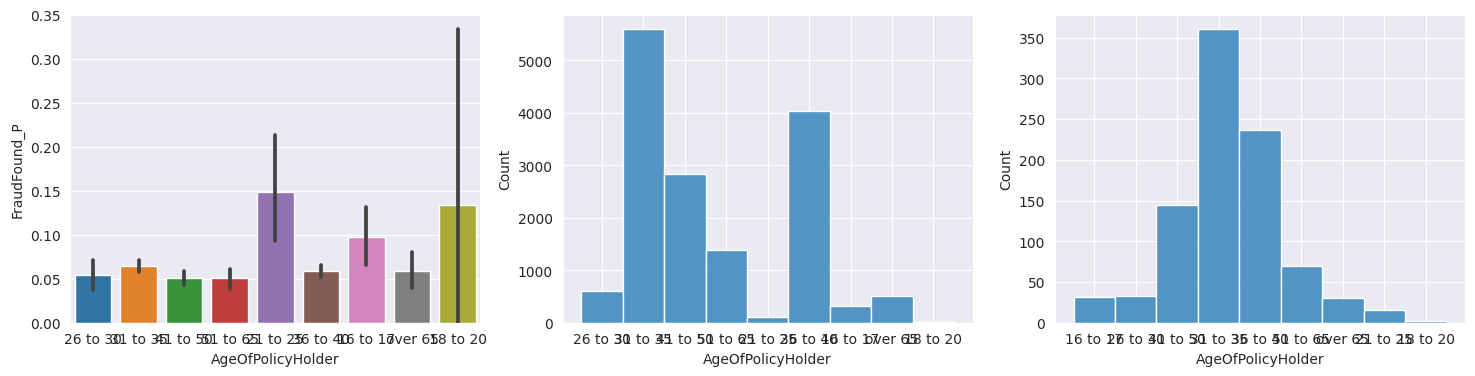

In [108]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
sns.barplot(data=df, x='AgeOfPolicyHolder', y='FraudFound_P', ax=ax1)
sns.histplot(df['AgeOfPolicyHolder'], ax=ax2)
sns.histplot(df['AgeOfPolicyHolder'][df['FraudFound_P']==1], ax=ax3)

<Axes: xlabel='NumberOfSuppliments', ylabel='Count'>

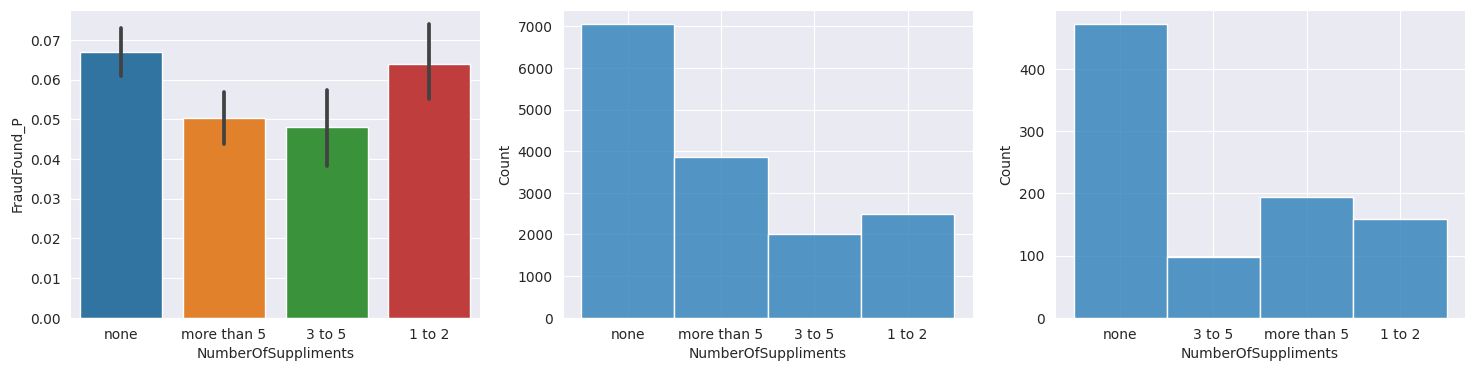

In [110]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
sns.barplot(data=df, x='NumberOfSuppliments', y='FraudFound_P', ax=ax1)
sns.histplot(df['NumberOfSuppliments'], ax=ax2)
sns.histplot(df['NumberOfSuppliments'][df['FraudFound_P']==1], ax=ax3)

<Axes: xlabel='BasePolicy', ylabel='Count'>

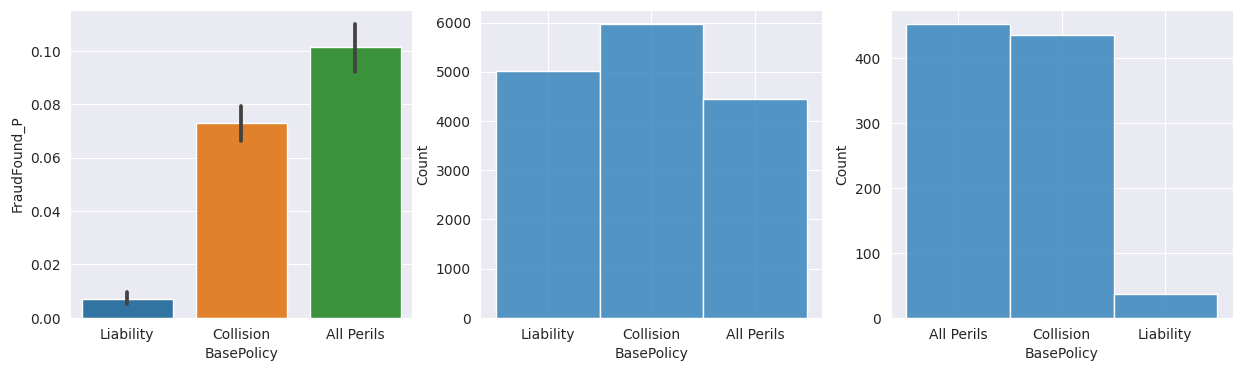

In [114]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
sns.barplot(data=df, x='BasePolicy', y='FraudFound_P', ax=ax1)
sns.histplot(df['BasePolicy'], ax=ax2)
sns.histplot(df['BasePolicy'][df['FraudFound_P']==1], ax=ax3)

In [65]:
df_.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

[Text(0.5, 1.0, 'FruadFoun_P=0')]

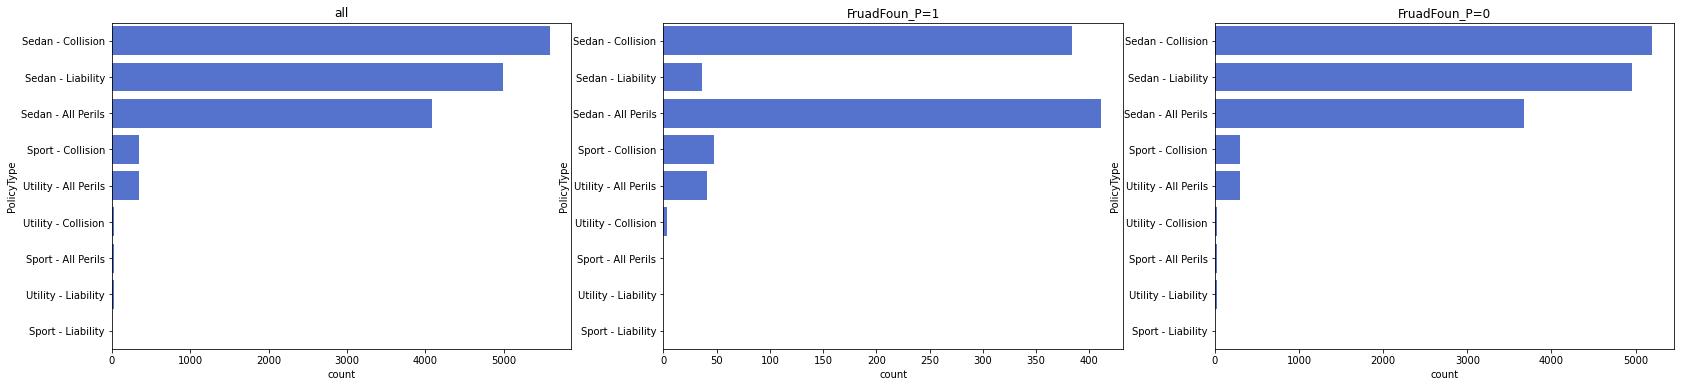

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 6))

sns.countplot(y='PolicyType',
              data=df,
              ax=ax1,
              orient='h',
              order=df['PolicyType'].value_counts().index,
              color='royalblue').set(title='all')

sns.countplot(y='PolicyType',
              data=df[df['FraudFound_P']==1],
              ax=ax2, orient='h',
              order=df['PolicyType'].value_counts().index,
              color='royalblue').set(title='FruadFoun_P=1')

sns.countplot(y='PolicyType',
              data=df[df['FraudFound_P']==0],
              ax=ax3, orient='h',
              order=df['PolicyType'].value_counts().index,
              color='royalblue').set(title='FruadFoun_P=0')

[Text(0.5, 1.0, 'FruadFoun_P=0')]

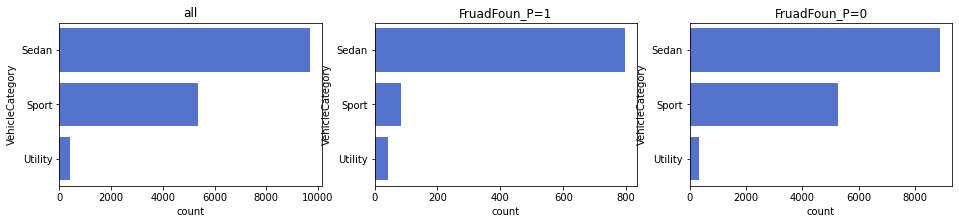

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 3))

sns.countplot(y='VehicleCategory',
              data=df,
              ax=ax1,
              orient='h',
              order=df['VehicleCategory'].value_counts().index,
              color='royalblue').set(title='all')

sns.countplot(y='VehicleCategory',
              data=df[df['FraudFound_P']==1],
              ax=ax2, orient='h',
              order=df['VehicleCategory'].value_counts().index,
              color='royalblue').set(title='FruadFoun_P=1')

sns.countplot(y='VehicleCategory',
              data=df[df['FraudFound_P']==0],
              ax=ax3, orient='h',
              order=df['VehicleCategory'].value_counts().index,
              color='royalblue').set(title='FruadFoun_P=0')

[Text(0.5, 1.0, 'FruadFoun_P=0')]

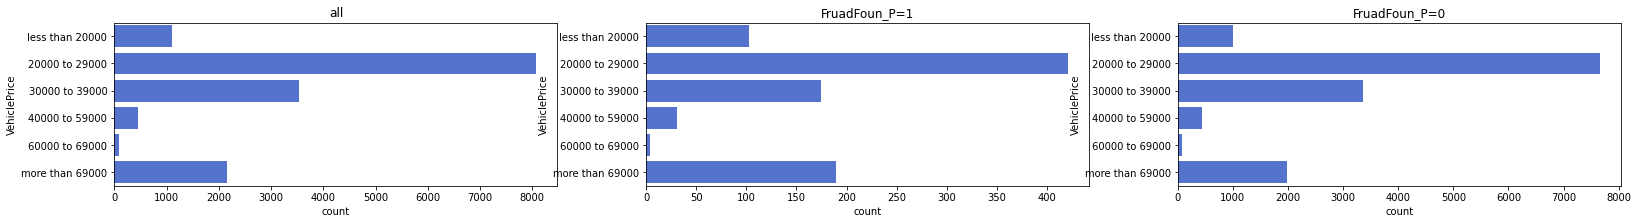

In [ ]:
ordered_vehicle_prices = ['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27, 3))

sns.countplot(y='VehiclePrice',
              data=df,
              ax=ax1,
              order=ordered_vehicle_prices,
              color='royalblue').set(title='all')

sns.countplot(y='VehiclePrice',
              data=df[df['FraudFound_P']==1],
              ax=ax2, order=ordered_vehicle_prices,
              color='royalblue').set(title='FruadFoun_P=1')

sns.countplot(y='VehiclePrice',
              data=df[df['FraudFound_P']==0],
              ax=ax3,
              order=ordered_vehicle_prices,
              color='royalblue').set(title='FruadFoun_P=0')

[Text(0.5, 1.0, 'FruadFoun_P=0')]

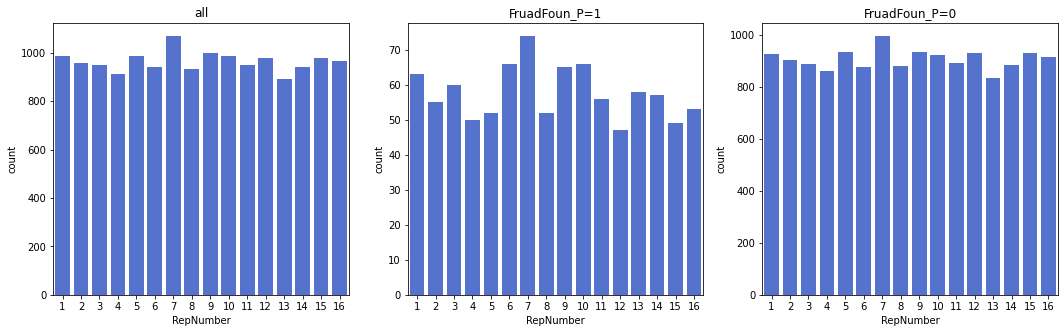

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='RepNumber', data=df, ax=ax1, color='royalblue').set(title='all')
sns.countplot(x='RepNumber', data=df[df['FraudFound_P']==1], ax=ax2, color='royalblue').set(title='FruadFoun_P=1')
sns.countplot(x='RepNumber', data=df[df['FraudFound_P']==0], ax=ax3, color='royalblue').set(title='FruadFoun_P=0')

[Text(0.5, 1.0, 'FruadFoun_P=0')]

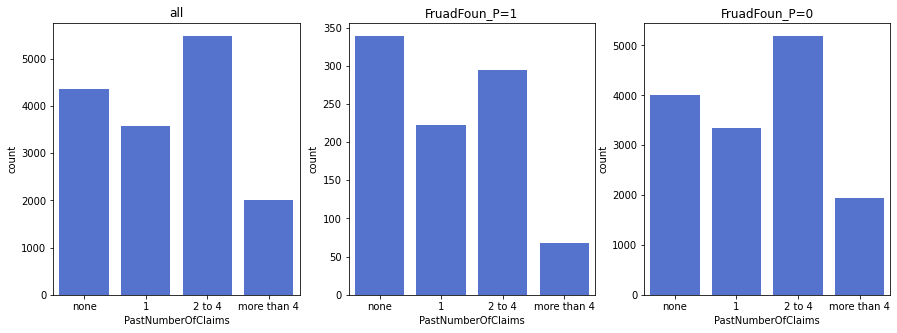

In [ ]:
ordered_past_claims = ['none', '1', '2 to 4', 'more than 4']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x='PastNumberOfClaims', data=df, ax=ax1, order=ordered_past_claims, color='royalblue').set(title='all')
sns.countplot(x='PastNumberOfClaims', data=df[df['FraudFound_P']==1], ax=ax2, order=ordered_past_claims, color='royalblue').set(title='FruadFoun_P=1')
sns.countplot(x='PastNumberOfClaims', data=df[df['FraudFound_P']==0], ax=ax3, order=ordered_past_claims, color='royalblue').set(title='FruadFoun_P=0')

[Text(0.5, 1.0, 'FruadFoun_P=0')]

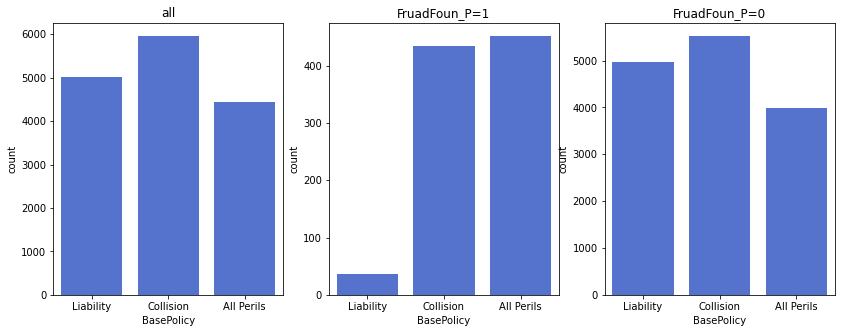

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))

sns.countplot(x='BasePolicy',
              data=df,
              ax=ax1,
              order=['Liability', 'Collision', 'All Perils'],
              color='royalblue').set(title='all')

sns.countplot(x='BasePolicy',
              data=df[df['FraudFound_P']==1],
              ax=ax2, order=['Liability', 'Collision', 'All Perils'],
              color='royalblue').set(title='FruadFoun_P=1')

sns.countplot(x='BasePolicy',
              data=df[df['FraudFound_P']==0],
              ax=ax3, order=['Liability', 'Collision', 'All Perils'],
              color='royalblue').set(title='FruadFoun_P=0')

##Preprocessing data

Features=='Yes'/'No'

In [ ]:
df['PoliceReportFiled'] = df['PoliceReportFiled'].map(lambda x: 1 if x=='Yes' else 0 )
df['PoliceReportFiled'].describe()

count    15420.000000
mean         0.027756
std          0.164279
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: PoliceReportFiled, dtype: float64

In [ ]:
df['WitnessPresent'] = df['WitnessPresent'].map(lambda x: 1 if x=='Yes' else 0 )
df['WitnessPresent'].describe()

count    15420.000000
mean         0.005642
std          0.074904
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: WitnessPresent, dtype: float64

'MonthClaimed'==0

In [ ]:
df['Month'].unique()

array(['Dec', 'Jan', 'Oct', 'Jun', 'Feb', 'Nov', 'Apr', 'Mar', 'Aug',
       'Jul', 'May', 'Sep'], dtype=object)

In [ ]:
df['MonthClaimed'].unique()

array(['Jan', 'Nov', 'Jul', 'Feb', 'Mar', 'Dec', 'Apr', 'Aug', 'May',
       'Jun', 'Sep', 'Oct', '0'], dtype=object)

In [ ]:
df[df['MonthClaimed'] == '0']

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
1516,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils


In [ ]:
df.drop(1516, axis=0, inplace=True)

In [ ]:
df[df['MonthClaimed'] == '0'].shape

(0, 33)

Deletion of the features

In [ ]:
df.drop(['PolicyNumber', 'RepNumber', 'Year'], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15419 entries, 0 to 15419
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15419 non-null  object
 1   WeekOfMonth           15419 non-null  int64 
 2   DayOfWeek             15419 non-null  object
 3   Make                  15419 non-null  object
 4   AccidentArea          15419 non-null  object
 5   DayOfWeekClaimed      15419 non-null  object
 6   MonthClaimed          15419 non-null  object
 7   WeekOfMonthClaimed    15419 non-null  int64 
 8   Sex                   15419 non-null  object
 9   MaritalStatus         15419 non-null  object
 10  Age                   15419 non-null  int64 
 11  Fault                 15419 non-null  object
 12  PolicyType            15419 non-null  object
 13  VehicleCategory       15419 non-null  object
 14  VehiclePrice          15419 non-null  object
 15  FraudFound_P          15419 non-null

#Metrics

In [ ]:
def calculate_metrics(y,y_pred):
    d = {'F1': [round(f1_score(y, y_pred),4)],
         'P-R': [round(average_precision_score(y, y_pred),4)],
         'accuracy': [round(accuracy_score(y, y_pred),4)],
         'recall': [round(recall_score(y, y_pred),4)],
         'precision': [round(precision_score(y, y_pred),4)],
        }

    return pd.DataFrame.from_dict(d)

#Experiment 1
Some categorical features as ordinal features

##Preparing DataFrame

In [ ]:
df1 = df.copy()

In [ ]:
df1.shape

(15419, 30)

##Mapping of ordinal features

In [ ]:
ordered_days_policy_a = ['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30']
ordered_days_policy_c = ['none', '8 to 15', '15 to 30', 'more than 30']
ordered_age_vehicle = ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7']
ordered_num_suppliments = ['none', '1 to 2', '3 to 5', 'more than 5']
ordered_address_changes = ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years']
ordered_num_cars = ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8']

ordinal_features = ['Month', 'DayOfWeek', 'DayOfWeekClaimed', 'MonthClaimed', 'VehiclePrice',
                   'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
                   'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars']

ordinal_features_dict = {'Month': ordered_months,
                         'DayOfWeek': ordered_days,
                         'DayOfWeekClaimed': ordered_days,
                         'MonthClaimed': ordered_months,
                         'VehiclePrice': ordered_vehicle_prices,
                         'Days_Policy_Accident': ordered_days_policy_a,
                         'Days_Policy_Claim': ordered_days_policy_c,
                         'PastNumberOfClaims': ordered_past_claims,
                         'AgeOfVehicle': ordered_age_vehicle,
                         'AgeOfPolicyHolder': ordered_age_holder,
                         'NumberOfSuppliments': ordered_num_suppliments,
                         'AddressChange_Claim': ordered_address_changes,
                         'NumberOfCars':  ordered_num_cars}

In [ ]:
for key in ordinal_features_dict:
  cat_mapping = {}
  for i, cat in enumerate(ordinal_features_dict[key]):
    cat_mapping[cat] = i+1 #w każdej iteracji doaje do słownika wartość dla klucza cat
  new_column = key + '_ord'
  df1[new_column] = df1[key].map(cat_mapping)
  print(df1[[key, new_column]].sample(5))

      Month  Month_ord
179     Jan          1
5066    Feb          2
7332    Mar          3
960     Jan          1
10764   Apr          4
       DayOfWeek  DayOfWeek_ord
12700    Tuesday              2
10727     Friday              5
574     Thursday              4
7438      Friday              5
8033   Wednesday              3
      DayOfWeekClaimed  DayOfWeekClaimed_ord
10118          Tuesday                     2
4975            Monday                     1
2300            Friday                     5
4015         Wednesday                     3
14261           Monday                     1
      MonthClaimed  MonthClaimed_ord
13969          Jul                 7
11598          Jun                 6
11235          Apr                 4
1616           Sep                 9
12525          Apr                 4
          VehiclePrice  VehiclePrice_ord
8612    40000 to 59000                 4
1679   less than 20000                 1
2148   less than 20000                 1
10490   20000 

In [ ]:
df1 = df1[['WeekOfMonth', 'Make', 'AccidentArea', 'WeekOfMonthClaimed', 'Sex', 'MaritalStatus',
          'Fault', 'PolicyType', 'VehiclePrice', 'FraudFound_P', 'Deductible', 'DriverRating',
          'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'BasePolicy', 'Month_ord', 'DayOfWeek_ord',
          'DayOfWeekClaimed_ord', 'MonthClaimed_ord', 'VehiclePrice_ord', 'Days_Policy_Accident_ord',
          'Days_Policy_Claim_ord', 'PastNumberOfClaims_ord', 'AgeOfVehicle_ord', 'AgeOfPolicyHolder_ord',
          'NumberOfSuppliments_ord', 'AddressChange_Claim_ord', 'NumberOfCars_ord']]

##X i y

In [ ]:
X1 = df1.copy()
X1.drop('FraudFound_P', axis=1, inplace=True)
y1 = df1['FraudFound_P']
X1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15419 entries, 0 to 15419
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   WeekOfMonth               15419 non-null  int64 
 1   Make                      15419 non-null  object
 2   AccidentArea              15419 non-null  object
 3   WeekOfMonthClaimed        15419 non-null  int64 
 4   Sex                       15419 non-null  object
 5   MaritalStatus             15419 non-null  object
 6   Fault                     15419 non-null  object
 7   PolicyType                15419 non-null  object
 8   VehiclePrice              15419 non-null  object
 9   Deductible                15419 non-null  int64 
 10  DriverRating              15419 non-null  int64 
 11  PoliceReportFiled         15419 non-null  int64 
 12  WitnessPresent            15419 non-null  int64 
 13  AgentType                 15419 non-null  object
 14  BasePolicy            

##Feature transformation

In [ ]:
X1 = pd.get_dummies(X1)

In [ ]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15419 entries, 0 to 15419
Data columns (total 68 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   WeekOfMonth                      15419 non-null  int64
 1   WeekOfMonthClaimed               15419 non-null  int64
 2   Deductible                       15419 non-null  int64
 3   DriverRating                     15419 non-null  int64
 4   PoliceReportFiled                15419 non-null  int64
 5   WitnessPresent                   15419 non-null  int64
 6   Month_ord                        15419 non-null  int64
 7   DayOfWeek_ord                    15419 non-null  int64
 8   DayOfWeekClaimed_ord             15419 non-null  int64
 9   MonthClaimed_ord                 15419 non-null  int64
 10  VehiclePrice_ord                 15419 non-null  int64
 11  Days_Policy_Accident_ord         15419 non-null  int64
 12  Days_Policy_Claim_ord            15419 non-nul

In [ ]:
X1.shape

(15419, 68)

##Split on a training and test set

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=6, stratify=y1)

print(f'Train data set: {X1_train.shape}, Frauds: {y1_train.sum()}')
print(f'Test data set: {X1_test.shape}, Frauds: {y1_test.sum()}')

Train data set: (11564, 68), Frauds: 692
Test data set: (3855, 68), Frauds: 231


##Feature selection

In [ ]:
#liczba cech
k1=30

###KBest - chi2

In [ ]:
skbest = SelectKBest(score_func=chi2, k=k1)
skbest.fit(X1_train, y1_train)

SelectKBest(k=30, score_func=<function chi2 at 0x7f7db95e9310>)

In [ ]:
chi_kbest_feats = [feat for feat in list(skbest.get_support()*X1_train.columns) if feat !='']
chi_kbest_feats

['Deductible',
 'Month_ord',
 'DayOfWeek_ord',
 'MonthClaimed_ord',
 'VehiclePrice_ord',
 'PastNumberOfClaims_ord',
 'AgeOfVehicle_ord',
 'AgeOfPolicyHolder_ord',
 'NumberOfSuppliments_ord',
 'AddressChange_Claim_ord',
 'Make_Accura',
 'Make_Mecedes',
 'Make_Saturn',
 'AccidentArea_Rural',
 'Sex_Female',
 'Fault_Policy Holder',
 'Fault_Third Party',
 'PolicyType_Sedan - All Perils',
 'PolicyType_Sedan - Collision',
 'PolicyType_Sedan - Liability',
 'PolicyType_Sport - Collision',
 'PolicyType_Utility - All Perils',
 'VehiclePrice_20000 to 29000',
 'VehiclePrice_30000 to 39000',
 'VehiclePrice_less than 20000',
 'VehiclePrice_more than 69000',
 'AgentType_Internal',
 'BasePolicy_All Perils',
 'BasePolicy_Collision',
 'BasePolicy_Liability']

###KBest - mutual_info_classif

In [ ]:
mif_kbest = SelectKBest(score_func=mutual_info_classif, k=k1)
mif_kbest.fit(X1_train, y1_train)

SelectKBest(k=30, score_func=<function mutual_info_classif at 0x7f7ded231e50>)

In [ ]:
mif_kbest_feats = [feat for feat in list(mif_kbest.get_support()*X1_train.columns) if feat !='']
mif_kbest_feats

['WeekOfMonth',
 'Deductible',
 'Month_ord',
 'DayOfWeekClaimed_ord',
 'VehiclePrice_ord',
 'Days_Policy_Accident_ord',
 'Days_Policy_Claim_ord',
 'PastNumberOfClaims_ord',
 'AgeOfVehicle_ord',
 'AgeOfPolicyHolder_ord',
 'AddressChange_Claim_ord',
 'NumberOfCars_ord',
 'Make_Ford',
 'Make_Honda',
 'Make_Jaguar',
 'Make_VW',
 'AccidentArea_Rural',
 'Sex_Male',
 'Fault_Policy Holder',
 'Fault_Third Party',
 'PolicyType_Sedan - All Perils',
 'PolicyType_Sedan - Liability',
 'PolicyType_Sport - Liability',
 'PolicyType_Utility - Collision',
 'VehiclePrice_less than 20000',
 'AgentType_External',
 'AgentType_Internal',
 'BasePolicy_All Perils',
 'BasePolicy_Collision',
 'BasePolicy_Liability']

###Mutual info Classif

In [ ]:
mif_importances = mutual_info_classif(X1_train, y1_train, random_state=6)

mif_feature_info = pd.concat([pd.DataFrame(X1_train.columns, columns=['feat']),
                    pd.DataFrame(mif_importances, columns=['importance'])
                   ], axis=1).sort_values(by='importance', ascending=False)

mif_feature_info.head(k1)

,feat,importance
67,BasePolicy_Liability,0.019285
50,PolicyType_Sedan - Liability,0.015069
47,Fault_Third Party,0.013357
46,Fault_Policy Holder,0.012946
48,PolicyType_Sedan - All Perils,0.007051
65,BasePolicy_All Perils,0.006149
2,Deductible,0.006101
17,AddressChange_Claim_ord,0.005481
60,VehiclePrice_60000 to 69000,0.005156
63,AgentType_External,0.004506


In [ ]:
fig = px.bar(mif_feature_info.sort_values(by='importance'), x='importance', y='feat',
             height=1150, width=1500,
             title='Feature importances for Mutual info Classif metod')

fig.show()

In [ ]:
mif_feats = mif_feature_info['feat'][mif_feature_info['importance'] > 0.0005].tolist()
len(mif_feats)

46

In [ ]:
mif_feats

['BasePolicy_Liability',
 'PolicyType_Sedan - Liability',
 'Fault_Third Party',
 'Fault_Policy Holder',
 'PolicyType_Sedan - All Perils',
 'BasePolicy_All Perils',
 'Deductible',
 'AddressChange_Claim_ord',
 'VehiclePrice_60000 to 69000',
 'AgentType_External',
 'PoliceReportFiled',
 'MaritalStatus_Married',
 'PastNumberOfClaims_ord',
 'PolicyType_Sedan - Collision',
 'VehiclePrice_20000 to 29000',
 'AgeOfPolicyHolder_ord',
 'Make_Saab',
 'BasePolicy_Collision',
 'PolicyType_Sport - All Perils',
 'WeekOfMonthClaimed',
 'PolicyType_Utility - All Perils',
 'Days_Policy_Accident_ord',
 'Make_Accura',
 'Make_Saturn',
 'MonthClaimed_ord',
 'Sex_Male',
 'VehiclePrice_ord',
 'NumberOfCars_ord',
 'VehiclePrice_less than 20000',
 'Make_BMW',
 'Sex_Female',
 'Make_Mercury',
 'DayOfWeekClaimed_ord',
 'PolicyType_Sport - Collision',
 'AgentType_Internal',
 'Make_Ford',
 'PolicyType_Sport - Liability',
 'Make_Mecedes',
 'Make_Honda',
 'Month_ord',
 'Make_Toyota',
 'AgeOfVehicle_ord',
 'Make_Dodge',

###Random Forest Importance

In [ ]:
rfi_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=6)

rfi_model.fit(X1_train, y1_train)

rfi_importances = rfi_model.feature_importances_

rfi_feature_info = pd.concat([pd.DataFrame(X1_train.columns, columns=['feat']),
                    pd.DataFrame(rfi_importances, columns=['importance'])
                   ], axis=1).sort_values(by='importance', ascending=False)

In [ ]:
rfi_feature_info.head(k1)

,feat,importance
47,Fault_Third Party,0.063158
46,Fault_Policy Holder,0.057368
9,MonthClaimed_ord,0.053040
6,Month_ord,0.048194
15,AgeOfPolicyHolder_ord,0.047517
7,DayOfWeek_ord,0.044568
67,BasePolicy_Liability,0.042444
8,DayOfWeekClaimed_ord,0.042088
14,AgeOfVehicle_ord,0.040528
0,WeekOfMonth,0.036272


In [ ]:
fig = px.bar(rfi_feature_info.sort_values(by='importance'), x='importance', y='feat',
             height=1150, width=1200,
             title='Feature importances for Random Forest Importance metod')

fig.show()

In [ ]:
rfi_feats = rfi_feature_info['feat'][rfi_feature_info['importance'] > 0.004].tolist()
len(rfi_feats)

45

In [ ]:
rfi_feats

['Fault_Third Party',
 'Fault_Policy Holder',
 'MonthClaimed_ord',
 'Month_ord',
 'AgeOfPolicyHolder_ord',
 'DayOfWeek_ord',
 'BasePolicy_Liability',
 'DayOfWeekClaimed_ord',
 'AgeOfVehicle_ord',
 'WeekOfMonth',
 'PolicyType_Sedan - Liability',
 'WeekOfMonthClaimed',
 'Deductible',
 'AddressChange_Claim_ord',
 'PastNumberOfClaims_ord',
 'DriverRating',
 'PolicyType_Sedan - All Perils',
 'NumberOfSuppliments_ord',
 'BasePolicy_All Perils',
 'VehiclePrice_ord',
 'PolicyType_Sedan - Collision',
 'NumberOfCars_ord',
 'BasePolicy_Collision',
 'MaritalStatus_Married',
 'Make_Accura',
 'AccidentArea_Rural',
 'MaritalStatus_Single',
 'AccidentArea_Urban',
 'Days_Policy_Accident_ord',
 'Make_Toyota',
 'PolicyType_Sport - Collision',
 'Make_Mazda',
 'Make_Honda',
 'VehiclePrice_20000 to 29000',
 'Make_Pontiac',
 'VehiclePrice_30000 to 39000',
 'VehiclePrice_more than 69000',
 'Make_Chevrolet',
 'Sex_Male',
 'Sex_Female',
 'Make_Ford',
 'VehiclePrice_40000 to 59000',
 'VehiclePrice_less than 2000

##Feature set selection

In [ ]:
selected_feats = {'all': X1_train.columns,
                  'chi_kbest_feats': chi_kbest_feats,
                  'mif_kbest_feats': mif_kbest_feats,
                  'mif_feats': mif_feats,
                  'rfi_feats': rfi_feats}

In [ ]:
results_sf_rf = pd.DataFrame()

rf = RandomForestClassifier(max_depth=10,
                             n_estimators=500,
                             class_weight='balanced',
                             random_state=6)

for i, feats in enumerate(selected_feats):
  X_train = X1_train[selected_feats[feats]].copy()

  print(f'Iteration: {i+1}')
  rf.fit(X_train, y1_train)
  y_train_pred = rf.predict(X_train)
  cm = calculate_metrics(y1_train, y_train_pred)

  param_dict = {'feat_set': feats,
                'F1': cm.at[0, 'F1'],
                'P-R': cm.at[0,'P-R'],
                'accuracy': cm.at[0, 'accuracy'],
                'reacall': cm.at[0, 'recall'],
                'precision': cm.at[0, 'precision']
                }

  results_sf_rf = results_sf_rf.append(pd.DataFrame(param_dict, index=[0]))

results_sf_rf.reset_index(drop=True, inplace=True)

results_sf_rf

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


,feat_set,F1,P-R,accuracy,reacall,precision
0,all,0.3096,0.1794,0.7443,0.9581,0.1846
1,chi_kbest_feats,0.3074,0.1775,0.7428,0.9538,0.1832
2,mif_kbest_feats,0.2776,0.1582,0.7007,0.9610,0.1622
3,mif_feats,0.2940,0.1683,0.7267,0.9509,0.1739
4,rfi_feats,0.3365,0.1980,0.7739,0.9581,0.2041


In [ ]:
ex1_feats = rfi_feats

##Models

### Random Forest

In [ ]:
gs1_params_rf ={'max_depth': [8, 9, 10],
               'n_estimators': [250, 300, 350, 400],
               'class_weight': ['balanced'],
               'random_state': [6]}

In [ ]:
X_train = X1_train[ex1_feats].copy()
y_train = y1_train

rf = RandomForestClassifier()

gs1_rf = GridSearchCV(rf,
                     param_grid=gs1_params_rf,
                     scoring='f1',
                     cv=10)

gs1_rf.fit(X_train, y_train)
gs1_rf_best = gs1_rf.best_estimator_
gs1_best_params = gs1_rf.best_params_
y_train_pred = gs1_rf_best.predict(X_train)
measures_gs1_rf = pd.concat([pd.DataFrame({'option': 'gs_rf',
                                          'max_depth': [gs1_best_params['max_depth']],
                                          'n_estimators': [gs1_best_params['n_estimators']],
                                          'best_score': round(gs1_rf.best_score_, 4)}),
                            calculate_metrics(y_train, y_train_pred)], axis=1)

measures_gs1_rf

,option,max_depth,n_estimators,best_score,F1,P-R,accuracy,recall,precision
0,gs_rf,9,300,0.2411,0.2882,0.1648,0.7177,0.9552,0.1697


###XGBoost

In [ ]:
gs1_params_xgb = {'n_estimators': [550, 600],
                 'max_depth': [3, 4],
                 'learning_rate': [0.1, 0.25],
                 'subsample': [0.75, 1.00],
                 'scale_pos_weight': [16.71]
                }

In [ ]:
X_train = X1_train[ex1_feats].copy()
y_train = y1_train

xgb = xgboost.XGBClassifier()

gs1_xgb = GridSearchCV(xgb,
                      param_grid=gs1_params_xgb,
                      scoring='f1',
                      cv=10)

gs1_xgb.fit(X_train, y_train)
gs1_xgb_best = gs1_xgb.best_estimator_
gs1_best_params = gs1_xgb.best_params_
y_train_pred = gs1_xgb_best.predict(X_train)
measures_gs1_xgb = pd.concat([pd.DataFrame({'option': 'gs_xgb',
                                          'max_depth': [gs1_best_params['max_depth']],
                                          'n_estimators': [gs1_best_params['n_estimators']],
                                          'best_score': round(gs1_xgb.best_score_, 4)}),
                              calculate_metrics(y_train, y_train_pred)], axis=1)

measures_gs1_xgb

,option,max_depth,n_estimators,best_score,F1,P-R,accuracy,recall,precision
0,gs_xgb,3,550,0.2482,0.3593,0.2161,0.7921,0.974,0.2203


In [ ]:
gs1_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 550,
 'scale_pos_weight': 16.71,
 'subsample': 1.0}

##Experiment 1 - Summary

In [ ]:
print('Experiment 1 - list of parameters and metrics')

results_ex1 = pd.concat([measures_gs1_rf, measures_gs1_xgb])
results_ex1

Experiment 1 - list of parameters and metrics


,option,max_depth,n_estimators,best_score,F1,P-R,accuracy,recall,precision
0,gs_rf,9,300,0.2411,0.2882,0.1648,0.7177,0.9552,0.1697
0,gs_xgb,3,550,0.2482,0.3593,0.2161,0.7921,0.9740,0.2203


#Experiment 2
Categorical features = nominal features

In [ ]:
df2 = df.copy()

##X i y

In [ ]:
X2 = df2.copy()
X2.drop('FraudFound_P', axis=1, inplace=True)
y2 = df2['FraudFound_P']
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15419 entries, 0 to 15419
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15419 non-null  object
 1   WeekOfMonth           15419 non-null  int64 
 2   DayOfWeek             15419 non-null  object
 3   Make                  15419 non-null  object
 4   AccidentArea          15419 non-null  object
 5   DayOfWeekClaimed      15419 non-null  object
 6   MonthClaimed          15419 non-null  object
 7   WeekOfMonthClaimed    15419 non-null  int64 
 8   Sex                   15419 non-null  object
 9   MaritalStatus         15419 non-null  object
 10  Age                   15419 non-null  int64 
 11  Fault                 15419 non-null  object
 12  PolicyType            15419 non-null  object
 13  VehicleCategory       15419 non-null  object
 14  VehiclePrice          15419 non-null  object
 15  Deductible            15419 non-null

##Feature transformation

In [ ]:
X2 = pd.get_dummies(X2)

In [ ]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15419 entries, 0 to 15419
Columns: 140 entries, WeekOfMonth to BasePolicy_Liability
dtypes: int64(7), uint8(133)
memory usage: 2.9 MB


In [ ]:
X2.shape

(15419, 140)

##Split on a training and test set

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=6, stratify=y2)

print(f'Train data set: {X2_train.shape}, Frauds: {y2_train.sum()}')
print(f'Test data set: {X2_test.shape}, Frauds: {y2_test.sum()}')

Train data set: (11564, 140), Frauds: 692
Test data set: (3855, 140), Frauds: 231


##Feature selection

In [ ]:
#number of selected features
k2=60

###KBest - chi2

In [ ]:
skbest = SelectKBest(score_func=chi2, k=k2)
skbest.fit(X2_train, y2_train)

SelectKBest(k=60, score_func=<function chi2 at 0x7f7db95e9310>)

In [ ]:
chi_kbest_feats = [feat for feat in list(skbest.get_support()*X2_train.columns) if feat !='']
chi_kbest_feats

['Age',
 'Deductible',
 'PoliceReportFiled',
 'Month_Aug',
 'Month_Dec',
 'Month_Jul',
 'Month_Nov',
 'DayOfWeek_Sunday',
 'DayOfWeek_Tuesday',
 'Make_Accura',
 'Make_Dodge',
 'Make_Mecedes',
 'Make_Saturn',
 'AccidentArea_Rural',
 'DayOfWeekClaimed_Friday',
 'DayOfWeekClaimed_Saturday',
 'DayOfWeekClaimed_Tuesday',
 'DayOfWeekClaimed_Wednesday',
 'MonthClaimed_Aug',
 'MonthClaimed_Dec',
 'MonthClaimed_Jul',
 'MonthClaimed_Nov',
 'Sex_Female',
 'Fault_Policy Holder',
 'Fault_Third Party',
 'PolicyType_Sedan - All Perils',
 'PolicyType_Sedan - Collision',
 'PolicyType_Sedan - Liability',
 'PolicyType_Sport - Collision',
 'PolicyType_Utility - All Perils',
 'VehicleCategory_Sedan',
 'VehicleCategory_Sport',
 'VehicleCategory_Utility',
 'VehiclePrice_20000 to 29000',
 'VehiclePrice_30000 to 39000',
 'VehiclePrice_less than 20000',
 'VehiclePrice_more than 69000',
 'Days_Policy_Accident_none',
 'Days_Policy_Claim_15 to 30',
 'PastNumberOfClaims_2 to 4',
 'PastNumberOfClaims_more than 4',
 

###KBest - mutual_info_classif

In [ ]:
mif_kbest = SelectKBest(score_func=mutual_info_classif, k=k2)
mif_kbest.fit(X2_train, y2_train)

SelectKBest(k=60, score_func=<function mutual_info_classif at 0x7f7ded231e50>)

In [ ]:
mif_kbest_feats = [feat for feat in list(mif_kbest.get_support()*X2_train.columns) if feat !='']
mif_kbest_feats

['WeekOfMonthClaimed',
 'Deductible',
 'DriverRating',
 'Month_Jan',
 'Month_May',
 'Month_Nov',
 'Month_Oct',
 'Month_Sep',
 'DayOfWeek_Saturday',
 'DayOfWeek_Thursday',
 'DayOfWeek_Tuesday',
 'DayOfWeek_Wednesday',
 'Make_Dodge',
 'Make_Lexus',
 'Make_Pontiac',
 'Make_Saab',
 'Make_Saturn',
 'AccidentArea_Urban',
 'DayOfWeekClaimed_Monday',
 'DayOfWeekClaimed_Saturday',
 'DayOfWeekClaimed_Tuesday',
 'DayOfWeekClaimed_Wednesday',
 'MonthClaimed_Aug',
 'MonthClaimed_Dec',
 'MonthClaimed_Jan',
 'MonthClaimed_Jul',
 'Sex_Male',
 'MaritalStatus_Divorced',
 'Fault_Policy Holder',
 'Fault_Third Party',
 'PolicyType_Sedan - All Perils',
 'PolicyType_Sedan - Collision',
 'PolicyType_Sedan - Liability',
 'PolicyType_Sport - All Perils',
 'PolicyType_Sport - Liability',
 'PolicyType_Utility - Collision',
 'VehicleCategory_Sedan',
 'VehicleCategory_Sport',
 'VehiclePrice_20000 to 29000',
 'VehiclePrice_60000 to 69000',
 'VehiclePrice_less than 20000',
 'Days_Policy_Accident_1 to 7',
 'Days_Polic

###Mutual info Classif

In [ ]:
mif_importances = mutual_info_classif(X2_train, y2_train, random_state=6)

mif_feature_info = pd.concat([pd.DataFrame(X2_train.columns, columns=['feat']),
                    pd.DataFrame(mif_importances, columns=['importance'])
                   ], axis=1).sort_values(by='importance', ascending=False)

In [ ]:
mif_feature_info.head(k2)

,feat,importance
76,PolicyType_Sedan - Liability,0.017144
139,BasePolicy_Liability,0.016943
72,Fault_Policy Holder,0.014147
83,VehicleCategory_Sedan,0.012279
73,Fault_Third Party,0.011138
84,VehicleCategory_Sport,0.010669
74,PolicyType_Sedan - All Perils,0.005980
67,Sex_Male,0.005961
137,BasePolicy_All Perils,0.005578
25,DayOfWeek_Wednesday,0.005515


In [ ]:
fig = px.bar(mif_feature_info.sort_values(by='importance'), x='importance', y='feat',
             height=2200, width=1200,
             title='Feature importances for Mutual info Classif metod')

fig.show()

In [ ]:
mif_feats = mif_feature_info['feat'][mif_feature_info['importance'] > 0.0007].tolist()
len(mif_feats)

61

In [ ]:
mif_feats

['PolicyType_Sedan - Liability',
 'BasePolicy_Liability',
 'Fault_Policy Holder',
 'VehicleCategory_Sedan',
 'Fault_Third Party',
 'VehicleCategory_Sport',
 'PolicyType_Sedan - All Perils',
 'Sex_Male',
 'BasePolicy_All Perils',
 'DayOfWeek_Wednesday',
 'Make_Jaguar',
 'VehiclePrice_20000 to 29000',
 'VehiclePrice_60000 to 69000',
 'AgentType_External',
 'WeekOfMonthClaimed',
 'AccidentArea_Rural',
 'VehiclePrice_less than 20000',
 'AgeOfVehicle_6 years',
 'Make_Nisson',
 'AgeOfPolicyHolder_18 to 20',
 'DayOfWeek_Thursday',
 'DayOfWeek_Monday',
 'AgeOfVehicle_4 years',
 'NumberOfCars_1 vehicle',
 'WitnessPresent',
 'Deductible',
 'Days_Policy_Accident_more than 30',
 'AgeOfPolicyHolder_36 to 40',
 'NumberOfSuppliments_none',
 'PoliceReportFiled',
 'MaritalStatus_Single',
 'Month_Jan',
 'Make_Ford',
 'Month_Nov',
 'MonthClaimed_Aug',
 'AddressChange_Claim_no change',
 'AgentType_Internal',
 'MonthClaimed_Oct',
 'PastNumberOfClaims_none',
 'Make_BMW',
 'Month_Jul',
 'NumberOfSuppliments_

###Random Forest Importance

In [ ]:
rfi_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=6)
rfi_model.fit(X2_train, y2_train)

rfi_importances = rfi_model.feature_importances_

rfi_feature_info = pd.concat([pd.DataFrame(X2_train.columns, columns=['feat']),
                    pd.DataFrame(rfi_importances, columns=['importance'])
                   ], axis=1).sort_values(by='importance', ascending=False)

In [ ]:
rfi_feature_info.head(k2)

,feat,importance
73,Fault_Third Party,0.061728
72,Fault_Policy Holder,0.059621
2,Age,0.053155
139,BasePolicy_Liability,0.029358
76,PolicyType_Sedan - Liability,0.028510
128,AddressChange_Claim_2 to 3 years,0.026738
0,WeekOfMonth,0.024466
1,WeekOfMonthClaimed,0.023782
84,VehicleCategory_Sport,0.022965
4,DriverRating,0.020810


In [ ]:
fig = px.bar(rfi_feature_info.sort_values(by='importance'), x='importance', y='feat',
             height=2200, width=1200,
             title='Feature importances for Random Forest Importance metod')

fig.show()

In [ ]:
rfi_feats = rfi_feature_info['feat'][rfi_feature_info['importance'] > 0.005].tolist()
len(rfi_feats)

69

In [ ]:
rfi_feats

['Fault_Third Party',
 'Fault_Policy Holder',
 'Age',
 'BasePolicy_Liability',
 'PolicyType_Sedan - Liability',
 'AddressChange_Claim_2 to 3 years',
 'WeekOfMonth',
 'WeekOfMonthClaimed',
 'VehicleCategory_Sport',
 'DriverRating',
 'VehicleCategory_Sedan',
 'Deductible',
 'PolicyType_Sedan - All Perils',
 'BasePolicy_All Perils',
 'BasePolicy_Collision',
 'PastNumberOfClaims_none',
 'AddressChange_Claim_no change',
 'PolicyType_Sedan - Collision',
 'AgeOfPolicyHolder_31 to 35',
 'DayOfWeek_Monday',
 'DayOfWeekClaimed_Wednesday',
 'AgeOfVehicle_more than 7',
 'NumberOfSuppliments_none',
 'DayOfWeekClaimed_Monday',
 'DayOfWeekClaimed_Tuesday',
 'AgeOfPolicyHolder_36 to 40',
 'AgeOfPolicyHolder_41 to 50',
 'Make_Accura',
 'PastNumberOfClaims_2 to 4',
 'AgeOfVehicle_6 years',
 'AgeOfVehicle_7 years',
 'DayOfWeekClaimed_Friday',
 'PolicyType_Sport - Collision',
 'AccidentArea_Urban',
 'VehiclePrice_more than 69000',
 'DayOfWeek_Sunday',
 'PastNumberOfClaims_1',
 'AccidentArea_Rural',
 'Mari

##Feature set selection

In [ ]:
selected_feats = {'all': X2_train.columns,
                  'chi_kbest_feats': chi_kbest_feats,
                  'mif_kbest_feats': mif_kbest_feats,
                  'mif_feats': mif_feats,
                  'rfi_feats': rfi_feats}

In [ ]:
y_train = y2_train

results_sf_rf = pd.DataFrame()

rf = RandomForestClassifier(max_depth=10,
                             n_estimators=500,
                             class_weight='balanced',
                             random_state=6)

for i, feats in enumerate(selected_feats):
  X_train = X2_train[selected_feats[feats]].copy()

  print(f'Iteration: {i+1}')
  rf.fit(X_train, y_train)
  y_train_pred = rf.predict(X_train)
  cm = calculate_metrics(y_train, y_train_pred)

  param_dict = {'feat_set': feats,
                'F1': cm.at[0, 'F1'],
                'P-R': cm.at[0,'P-R'],
                'accuracy': cm.at[0, 'accuracy'],
                'reacall': cm.at[0, 'recall'],
                'precision': cm.at[0, 'precision']
                }

  results_sf_rf = results_sf_rf.append(pd.DataFrame(param_dict, index=[0]))

results_sf_rf.reset_index(drop=True, inplace=True)

results_sf_rf

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


,feat_set,F1,P-R,accuracy,reacall,precision
0,all,0.2973,0.1713,0.7281,0.9610,0.1758
1,chi_kbest_feats,0.2901,0.1664,0.7190,0.9595,0.1709
2,mif_kbest_feats,0.2769,0.1577,0.6996,0.9610,0.1617
3,mif_feats,0.2552,0.1436,0.6648,0.9595,0.1472
4,rfi_feats,0.3177,0.1855,0.7522,0.9639,0.1902


In [ ]:
ex2_feats = rfi_feats

##Models

### Random Forest

In [ ]:
gs2_params_rf ={'max_depth': [9, 10, 11],
               'n_estimators': [300, 350, 400],
               'class_weight': ['balanced'],
               'random_state': [6]}

In [ ]:
X_train = X2_train[ex2_feats].copy()
y_train = y2_train

rf = RandomForestClassifier()

gs2_rf = GridSearchCV(rf,
                     param_grid=gs2_params_rf,
                     scoring='f1',
                     cv=10)

gs2_rf.fit(X_train, y_train)
gs2_rf_best = gs2_rf.best_estimator_
gs2_best_params = gs2_rf.best_params_
y_train_pred = gs2_rf_best.predict(X_train)

measures_gs2_rf = pd.concat([pd.DataFrame({'option': 'gs_rf',
                                          'max_depth': [gs2_best_params['max_depth']],
                                          'n_estimators': [gs2_best_params['n_estimators']],
                                          'best_score': round(gs2_rf.best_score_, 4)}),
                            calculate_metrics(y_train, y_train_pred)], axis=1)

measures_gs2_rf

,option,max_depth,n_estimators,best_score,F1,P-R,accuracy,recall,precision
0,gs_rf,10,350,0.2381,0.3163,0.1842,0.7514,0.961,0.1893


###XGBoost

In [ ]:
gs2_params_xgb = {'n_estimators': [500, 550],
                 'max_depth': [3, 4],
                 'learning_rate': [0.1, 0.25],
                 'subsample': [0.75, 1.00],
                 'scale_pos_weight': [16.71]
                }

In [ ]:
X_train = X2_train[ex2_feats].copy()
y_train = y2_train

xgb = xgboost.XGBClassifier()

gs2_xgb = GridSearchCV(xgb,
                      param_grid=gs2_params_xgb,
                      scoring='f1',
                      cv=10)

gs2_xgb.fit(X_train, y_train)
gs2_xgb_best = gs2_xgb.best_estimator_
gs2_best_params = gs2_xgb.best_params_
y_train_pred = gs2_xgb_best.predict(X_train)

measures_gs2_xgb = pd.concat([pd.DataFrame({'option': 'gs_xgb',
                                          'max_depth': [gs2_best_params['max_depth']],
                                          'n_estimators': [gs2_best_params['n_estimators']],
                                          'best_score': round(gs2_xgb.best_score_, 4)}),
                              calculate_metrics(y_train, y_train_pred)], axis=1)

measures_gs2_xgb

,option,max_depth,n_estimators,best_score,F1,P-R,accuracy,recall,precision
0,gs_xgb,3,500,0.2652,0.4036,0.2509,0.8257,0.9855,0.2537


In [ ]:
gs2_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 500,
 'scale_pos_weight': 16.71,
 'subsample': 0.75}

###Experiment 2 - summary

In [ ]:
print('Experiment 1 - list of parameters and metrics')

results_ex2 = pd.concat([measures_gs2_rf, measures_gs2_xgb])
results_ex2

Experiment 1 - list of parameters and metrics


,option,max_depth,n_estimators,best_score,F1,P-R,accuracy,recall,precision
0,gs_rf,10,350,0.2381,0.3163,0.1842,0.7514,0.9610,0.1893
0,gs_xgb,3,500,0.2652,0.4036,0.2509,0.8257,0.9855,0.2537


#Results - summary

In [ ]:
results = pd.concat([results_ex1, results_ex2], keys=['Experiment_1', 'Experiment_2'])
results

option  max_depth  n_estimators  best_score      F1     P-R  \
Experiment_1 0   gs_rf          9           300      0.2411  0.2882  0.1648   
             0  gs_xgb          3           550      0.2482  0.3593  0.2161   
Experiment_2 0   gs_rf         10           350      0.2381  0.3163  0.1842   
             0  gs_xgb          3           500      0.2652  0.4036  0.2509   

                accuracy  recall  precision  
Experiment_1 0    0.7177  0.9552     0.1697  
             0    0.7921  0.9740     0.2203  
Experiment_2 0    0.7514  0.9610     0.1893  
             0    0.8257  0.9855     0.2537

In [ ]:
best_model = gs2_xgb_best

X_test = X2_test[ex2_feats].copy()
y_test = y2_test

y_test_pred = best_model.predict(X_test)

In [ ]:
calculate_metrics(y_test, y_test_pred)

,F1,P-R,accuracy,recall,precision
0,0.2331,0.1096,0.773,0.5758,0.1462


In [ ]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
cf_matrix

array([[2847,  777],
       [  98,  133]])

<AxesSubplot:>

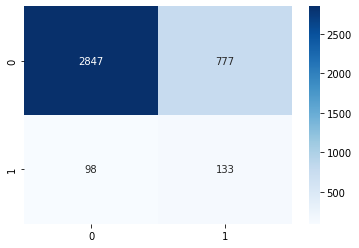

In [ ]:
sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

<AxesSubplot:>

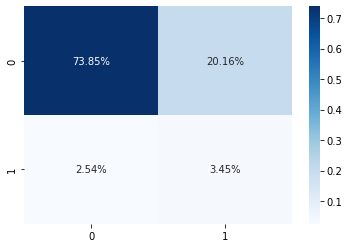

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt = '.2%',
            cmap='Blues')

##Shap

In [ ]:
explainer = shap.TreeExplainer(best_model)

In [ ]:
shap_values = explainer.shap_values(X_test)

/usr/local/lib/python3.8/dist-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



Feature significance chart


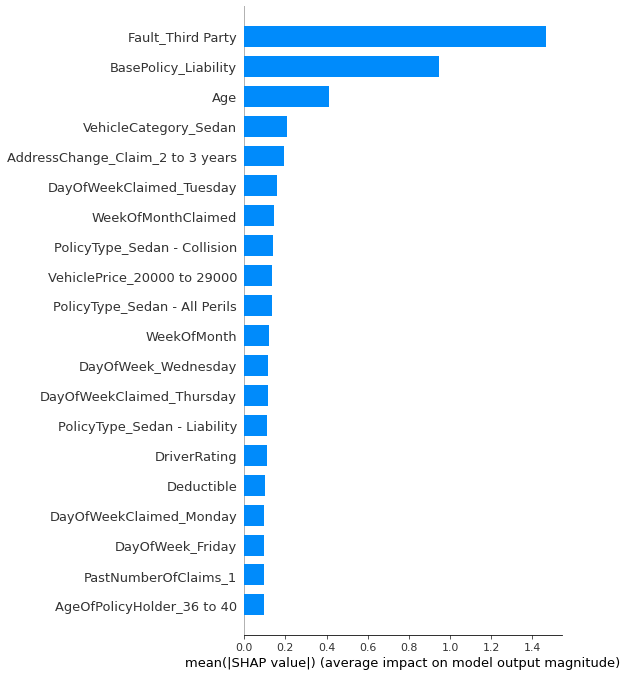

In [ ]:
print('Feature significance chart')
shap.summary_plot(shap_values, X_test, plot_type='bar')